# Load data

In [1]:
import pandas as pd
from constants import NULLABLE_MEASURES
from utils.class_patient import Patients

patients = Patients.loadPatients()
patients.fillMissingMeasureValue(NULLABLE_MEASURES, 0)

# Remove missing data

## Remove features with more than 20% missing

In [2]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


## Remove patients with more than 20% missing features

In [3]:
patients.removePatientByMissingFeatures()
len(patients)

1206

## Display insight

In [4]:
# dfData = patients.getMeasuresBetween(pd.Timedelta(hours=-6), pd.Timedelta(hours=24), "first")

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(patients.getMeasures())

Counter({'age': 1206,
         'chronic_pulmonary_disease': 1206,
         'ckd_stage': 1206,
         'congestive_heart_failure': 1206,
         'dka_type': 1206,
         'gender': 1206,
         'history_aci': 1206,
         'history_ami': 1206,
         'hypertension': 1206,
         'liver_disease': 1206,
         'macroangiopathy': 1206,
         'malignant_cancer': 1206,
         'mechanical_ventilation': 1206,
         'microangiopathy': 1206,
         'oasis': 1206,
         'preiculos': 1206,
         'race': 1206,
         'saps2': 1206,
         'sofa': 1206,
         'use_NaHCO3': 1206,
         'uti': 1206,
         'ag': 1205,
         'bg': 1205,
         'bicarbonate': 1205,
         'bun': 1205,
         'chloride': 1205,
         'egfr': 1205,
         'hr': 1205,
         'potassium': 1205,
         'scr': 1205,
         'sodium': 1205,
         'dbp': 1204,
         'gcs': 1204,
         'gcs_unable': 1204,
         'rr': 1204,
         'sbp': 1204,
         'calci

In [5]:
akdCount = sum([p.akdPositive for p in patients.patientList])

akdCount / len(patients)

0.39303482587064675

# Machine learning

In [6]:
from constants import CATEGORICAL_MEASURES


idColumns = ["subject_id", "hadm_id", "stay_id"]
categoryColumns = CATEGORICAL_MEASURES
labelColumn = "akd"

## Split train-test

In [7]:
splitedPatients = patients.split(5, 27)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

## Define model

In [8]:
import xgboost as xgb

how = "first"

params = {
    "validate_parameters": True,
    "device": "gpu",  # Use GPU acceleration
    "n_jobs": -1,  # Use all CPU cores
    "eval_metric": "logloss",  # Evaluation metric
    "max_depth": 6,  # Maximum depth of a tree
    "min_child_weight": 1,  # Minimum sum of instance weight (hessian) needed in a child
    "gamma": 0,  # Minimum loss reduction required to make a further partition on a leaf node
    "subsample": 0.8,  # Subsample ratio of the training instances
    "colsample_bytree": 0.8,  # Subsample ratio of columns when constructing each tree
    "reg_alpha": 0.01,  # L1 regularization term on weights
    "reg_lambda": 1,  # L2 regularization term on weights
    "objective": "binary:logistic",  # Binary classification objective
    "n_estimators": 1000,  # Number of trees
    "learning_rate": 0.01,  # Learning rate
    "early_stopping_rounds": 10,  # Early stopping
    "verbose": 0,  # Verbosity
}


def createModel():
    model = xgb.XGBClassifier(**params)
    return model

`functionize-notebook` has modified this notebook during execution. The following variables have been injected:

- how: last


## Without validate

### Without fill missing data

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from utils.prepare_data import normalizeData


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list.append(accuracy_score(y_test, y_pred))
    precision_score_list.append(precision_score(y_test, y_pred))
    recall_score_list.append(recall_score(y_test, y_pred))
    auc_score_list.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:05:37] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:05:38] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:05:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:05:55] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:04] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:12] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:

print(f"Average AUC: {np.mean(auc_score_list)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list)}")
print(f"Average Precision: {np.mean(precision_score_list)}")
print(f"Average Recall: {np.mean(recall_score_list)}")

Average AUC: 0.8030714083789647
Average Accuracy: 0.7446143822228318
Average Precision: 0.6960758155716302
Average Recall: 0.6266965285554311


### Fill missing with knn

In [12]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_knn = []
precision_score_list_knn = []
recall_score_list_knn = []
auc_score_list_knn = []
for trainPatients, testPatients in trainTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, _ = normalizeAndFillData(dfTrain, dfTest)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_train, y_train)], verbose=False)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_knn.append(precision_score(y_test, y_pred))
    recall_score_list_knn.append(recall_score(y_test, y_pred))
    auc_score_list_knn.append(roc_auc_score(y_test, y_pred_proba))



/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:21] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:39] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:06:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:

print(f"Average AUC: {np.mean(auc_score_list_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_knn)}")

Average AUC: 0.7928600365885359
Average Accuracy: 0.738801824354446
Average Precision: 0.6928673300712281
Average Recall: 0.6097200447928331


## With validate

### Without fill missing data

In [14]:
from utils.prepare_data import normalizeData


accuracy_score_list_val = []
precision_score_list_val = []
recall_score_list_val = []
auc_score_list_val = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn]) # type: ignore
    y_val = dfVal[labelColumn] # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val.append(accuracy_score(y_test, y_pred))
    precision_score_list_val.append(precision_score(y_test, y_pred))
    recall_score_list_val.append(recall_score(y_test, y_pred))
    auc_score_list_val.append(roc_auc_score(y_test, y_pred_proba))


[0]	validation_0-logloss:0.66642


[1]	validation_0-logloss:0.66378


[2]	validation_0-logloss:0.66092


[3]	validation_0-logloss:0.65850


[4]	validation_0-logloss:0.65561


[5]	validation_0-logloss:0.65318


[6]	validation_0-logloss:0.65104


[7]	validation_0-logloss:0.64833


[8]	validation_0-logloss:0.64613


[9]	validation_0-logloss:0.64372


[10]	validation_0-logloss:0.64106


[11]	validation_0-logloss:0.63873


[12]	validation_0-logloss:0.63701


[13]	validation_0-logloss:0.63454


[14]	validation_0-logloss:0.63197


[15]	validation_0-logloss:0.62944


[16]	validation_0-logloss:0.62720


[17]	validation_0-logloss:0.62505


[18]	validation_0-logloss:0.62338


[19]	validation_0-logloss:0.62220


[20]	validation_0-logloss:0.62049


[21]	validation_0-logloss:0.61868


[22]	validation_0-logloss:0.61683


[23]	validation_0-logloss:0.61520


[24]	validation_0-logloss:0.61375


[25]	validation_0-logloss:0.61294


[26]	validation_0-logloss:0.61157


[27]	validation_0-logloss:0.60996


[28]	validation_0-logloss:0.60813


[29]	validation_0-logloss:0.60636


[30]	validation_0-logloss:0.60471


[31]	validation_0-logloss:0.60336


[32]	validation_0-logloss:0.60121


[33]	validation_0-logloss:0.59982


[34]	validation_0-logloss:0.59812


[35]	validation_0-logloss:0.59687


[36]	validation_0-logloss:0.59505


[37]	validation_0-logloss:0.59357


[38]	validation_0-logloss:0.59200


[39]	validation_0-logloss:0.59062


[40]	validation_0-logloss:0.58915


[41]	validation_0-logloss:0.58795


[42]	validation_0-logloss:0.58702


[43]	validation_0-logloss:0.58535


[44]	validation_0-logloss:0.58428


[45]	validation_0-logloss:0.58329


[46]	validation_0-logloss:0.58195


[47]	validation_0-logloss:0.58079


[48]	validation_0-logloss:0.57972


[49]	validation_0-logloss:0.57863


[50]	validation_0-logloss:0.57725


[51]	validation_0-logloss:0.57613


[52]	validation_0-logloss:0.57489


[53]	validation_0-logloss:0.57363


[54]	validation_0-logloss:0.57257


[55]	validation_0-logloss:0.57156


[56]	validation_0-logloss:0.57011


[57]	validation_0-logloss:0.56904


[58]	validation_0-logloss:0.56831


[59]	validation_0-logloss:0.56741


[60]	validation_0-logloss:0.56625


[61]	validation_0-logloss:0.56532


[62]	validation_0-logloss:0.56427


[63]	validation_0-logloss:0.56305


[64]	validation_0-logloss:0.56243


[65]	validation_0-logloss:0.56134


[66]	validation_0-logloss:0.56030


[67]	validation_0-logloss:0.55947


[68]	validation_0-logloss:0.55839


[69]	validation_0-logloss:0.55782


[70]	validation_0-logloss:0.55651


[71]	validation_0-logloss:0.55582


[72]	validation_0-logloss:0.55462


[73]	validation_0-logloss:0.55342


[74]	validation_0-logloss:0.55276


[75]	validation_0-logloss:0.55226


[76]	validation_0-logloss:0.55124


[77]	validation_0-logloss:0.55000


[78]	validation_0-logloss:0.54960


[79]	validation_0-logloss:0.54854


[80]	validation_0-logloss:0.54783


[81]	validation_0-logloss:0.54733


[82]	validation_0-logloss:0.54677


[83]	validation_0-logloss:0.54610


[84]	validation_0-logloss:0.54497


[85]	validation_0-logloss:0.54425


[86]	validation_0-logloss:0.54341


[87]	validation_0-logloss:0.54240


[88]	validation_0-logloss:0.54178


[89]	validation_0-logloss:0.54078


[90]	validation_0-logloss:0.54005


[91]	validation_0-logloss:0.53977


[92]	validation_0-logloss:0.53876


[93]	validation_0-logloss:0.53817


[94]	validation_0-logloss:0.53765


[95]	validation_0-logloss:0.53678


[96]	validation_0-logloss:0.53594


[97]	validation_0-logloss:0.53519


[98]	validation_0-logloss:0.53455


[99]	validation_0-logloss:0.53391


[100]	validation_0-logloss:0.53334


[101]	validation_0-logloss:0.53253


[102]	validation_0-logloss:0.53153


[103]	validation_0-logloss:0.53105


[104]	validation_0-logloss:0.53043


[105]	validation_0-logloss:0.52978


[106]	validation_0-logloss:0.52926


[107]	validation_0-logloss:0.52856


[108]	validation_0-logloss:0.52798


[109]	validation_0-logloss:0.52749


[110]	validation_0-logloss:0.52684


[111]	validation_0-logloss:0.52607


[112]	validation_0-logloss:0.52573


[113]	validation_0-logloss:0.52486


[114]	validation_0-logloss:0.52440


[115]	validation_0-logloss:0.52394


[116]	validation_0-logloss:0.52374


[117]	validation_0-logloss:0.52292


[118]	validation_0-logloss:0.52204


[119]	validation_0-logloss:0.52179


[120]	validation_0-logloss:0.52117


[121]	validation_0-logloss:0.52122


[122]	validation_0-logloss:0.52062


[123]	validation_0-logloss:0.52043


[124]	validation_0-logloss:0.52032


[125]	validation_0-logloss:0.51993


[126]	validation_0-logloss:0.51989


[127]	validation_0-logloss:0.51940


[128]	validation_0-logloss:0.51961


[129]	validation_0-logloss:0.51917


[130]	validation_0-logloss:0.51863


[131]	validation_0-logloss:0.51838


[132]	validation_0-logloss:0.51776


[133]	validation_0-logloss:0.51719


[134]	validation_0-logloss:0.51716


[135]	validation_0-logloss:0.51677


[136]	validation_0-logloss:0.51705


[137]	validation_0-logloss:0.51693


[138]	validation_0-logloss:0.51634


[139]	validation_0-logloss:0.51581


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:10] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[140]	validation_0-logloss:0.51538


[141]	validation_0-logloss:0.51513


[142]	validation_0-logloss:0.51508


[143]	validation_0-logloss:0.51468


[144]	validation_0-logloss:0.51416


[145]	validation_0-logloss:0.51348


[146]	validation_0-logloss:0.51329


[147]	validation_0-logloss:0.51266


[148]	validation_0-logloss:0.51234


[149]	validation_0-logloss:0.51173


[150]	validation_0-logloss:0.51134


[151]	validation_0-logloss:0.51126


[152]	validation_0-logloss:0.51093


[153]	validation_0-logloss:0.51065


[154]	validation_0-logloss:0.51041


[155]	validation_0-logloss:0.51026


[156]	validation_0-logloss:0.50983


[157]	validation_0-logloss:0.50951


[158]	validation_0-logloss:0.50924


[159]	validation_0-logloss:0.50878


[160]	validation_0-logloss:0.50848


[161]	validation_0-logloss:0.50823


[162]	validation_0-logloss:0.50817


[163]	validation_0-logloss:0.50790


[164]	validation_0-logloss:0.50748


[165]	validation_0-logloss:0.50734


[166]	validation_0-logloss:0.50725


[167]	validation_0-logloss:0.50682


[168]	validation_0-logloss:0.50655


[169]	validation_0-logloss:0.50642


[170]	validation_0-logloss:0.50599


[171]	validation_0-logloss:0.50579


[172]	validation_0-logloss:0.50566


[173]	validation_0-logloss:0.50577


[174]	validation_0-logloss:0.50567


[175]	validation_0-logloss:0.50509


[176]	validation_0-logloss:0.50491


[177]	validation_0-logloss:0.50449


[178]	validation_0-logloss:0.50420


[179]	validation_0-logloss:0.50413


[180]	validation_0-logloss:0.50396


[181]	validation_0-logloss:0.50365


[182]	validation_0-logloss:0.50358


[183]	validation_0-logloss:0.50361


[184]	validation_0-logloss:0.50303


[185]	validation_0-logloss:0.50319


[186]	validation_0-logloss:0.50265


[187]	validation_0-logloss:0.50273


[188]	validation_0-logloss:0.50214


[189]	validation_0-logloss:0.50190


[190]	validation_0-logloss:0.50122


[191]	validation_0-logloss:0.50087


[192]	validation_0-logloss:0.50080


[193]	validation_0-logloss:0.50079


[194]	validation_0-logloss:0.50050


[195]	validation_0-logloss:0.50036


[196]	validation_0-logloss:0.50044


[197]	validation_0-logloss:0.50024


[198]	validation_0-logloss:0.50016


[199]	validation_0-logloss:0.50004


[200]	validation_0-logloss:0.49984


[201]	validation_0-logloss:0.49954


[202]	validation_0-logloss:0.49922


[203]	validation_0-logloss:0.49896


[204]	validation_0-logloss:0.49880


[205]	validation_0-logloss:0.49907


[206]	validation_0-logloss:0.49882


[207]	validation_0-logloss:0.49864


[208]	validation_0-logloss:0.49836


[209]	validation_0-logloss:0.49829


[210]	validation_0-logloss:0.49824


[211]	validation_0-logloss:0.49828


[212]	validation_0-logloss:0.49783


[213]	validation_0-logloss:0.49719


[214]	validation_0-logloss:0.49724


[215]	validation_0-logloss:0.49721


[216]	validation_0-logloss:0.49718


[217]	validation_0-logloss:0.49709


[218]	validation_0-logloss:0.49665


[219]	validation_0-logloss:0.49661


[220]	validation_0-logloss:0.49653


[221]	validation_0-logloss:0.49664


[222]	validation_0-logloss:0.49648

[223]	validation_0-logloss:0.49646


[224]	validation_0-logloss:0.49650


[225]	validation_0-logloss:0.49640


[226]	validation_0-logloss:0.49626


[227]	validation_0-logloss:0.49647


[228]	validation_0-logloss:0.49642


[229]	validation_0-logloss:0.49677


[230]	validation_0-logloss:0.49665

[231]	validation_0-logloss:0.49688


[232]	validation_0-logloss:0.49684


[233]	validation_0-logloss:0.49673


[234]	validation_0-logloss:0.49666


[235]	validation_0-logloss:0.49685


[236]	validation_0-logloss:0.49705


[0]	validation_0-logloss:0.66770


[1]	validation_0-logloss:0.66564


[2]	validation_0-logloss:0.66334


[3]	validation_0-logloss:0.66121


[4]	validation_0-logloss:0.65852


[5]	validation_0-logloss:0.65593


[6]	validation_0-logloss:0.65392


[7]	validation_0-logloss:0.65170


[8]	validation_0-logloss:0.65013


[9]	validation_0-logloss:0.64817


[10]	validation_0-logloss:0.64612


[11]	validation_0-logloss:0.64460


[12]	validation_0-logloss:0.64255


[13]	validation_0-logloss:0.64117


[14]	validation_0-logloss:0.63898


[15]	validation_0-logloss:0.63708


[16]	validation_0-logloss:0.63530


[17]	validation_0-logloss:0.63297


[18]	validation_0-logloss:0.63085


[19]	validation_0-logloss:0.62907


[20]	validation_0-logloss:0.62750


[21]	validation_0-logloss:0.62601


[22]	validation_0-logloss:0.62431


[23]	validation_0-logloss:0.62216


[24]	validation_0-logloss:0.62040


[25]	validation_0-logloss:0.61866


[26]	validation_0-logloss:0.61672


[27]	validation_0-logloss:0.61542


[28]	validation_0-logloss:0.61408


[29]	validation_0-logloss:0.61300


[30]	validation_0-logloss:0.61158


[31]	validation_0-logloss:0.60988


[32]	validation_0-logloss:0.60822


[33]	validation_0-logloss:0.60692


[34]	validation_0-logloss:0.60547


[35]	validation_0-logloss:0.60358


[36]	validation_0-logloss:0.60248


[37]	validation_0-logloss:0.60080


[38]	validation_0-logloss:0.59912


[39]	validation_0-logloss:0.59759


[40]	validation_0-logloss:0.59597


[41]	validation_0-logloss:0.59495


[42]	validation_0-logloss:0.59359


[43]	validation_0-logloss:0.59284


[44]	validation_0-logloss:0.59135


[45]	validation_0-logloss:0.58985


[46]	validation_0-logloss:0.58904


[47]	validation_0-logloss:0.58762


[48]	validation_0-logloss:0.58683


[49]	validation_0-logloss:0.58553


[50]	validation_0-logloss:0.58468


[51]	validation_0-logloss:0.58327


[52]	validation_0-logloss:0.58245


[53]	validation_0-logloss:0.58157


[54]	validation_0-logloss:0.58045


[55]	validation_0-logloss:0.57927


[56]	validation_0-logloss:0.57892


[57]	validation_0-logloss:0.57765


[58]	validation_0-logloss:0.57683


[59]	validation_0-logloss:0.57577


[60]	validation_0-logloss:0.57458


[61]	validation_0-logloss:0.57363


[62]	validation_0-logloss:0.57253


[63]	validation_0-logloss:0.57176


[64]	validation_0-logloss:0.57040


[65]	validation_0-logloss:0.56955


[66]	validation_0-logloss:0.56812


[67]	validation_0-logloss:0.56703


[68]	validation_0-logloss:0.56626


[69]	validation_0-logloss:0.56531


[70]	validation_0-logloss:0.56450


[71]	validation_0-logloss:0.56348


[72]	validation_0-logloss:0.56260


[73]	validation_0-logloss:0.56188


[74]	validation_0-logloss:0.56091


[75]	validation_0-logloss:0.56008


[76]	validation_0-logloss:0.55942


[77]	validation_0-logloss:0.55814


[78]	validation_0-logloss:0.55742


[79]	validation_0-logloss:0.55650


[80]	validation_0-logloss:0.55606


[81]	validation_0-logloss:0.55517


[82]	validation_0-logloss:0.55437


[83]	validation_0-logloss:0.55367


[84]	validation_0-logloss:0.55290


[85]	validation_0-logloss:0.55228


[86]	validation_0-logloss:0.55180


[87]	validation_0-logloss:0.55119


[88]	validation_0-logloss:0.55011


[89]	validation_0-logloss:0.54969


[90]	validation_0-logloss:0.54885


[91]	validation_0-logloss:0.54810


[92]	validation_0-logloss:0.54751


[93]	validation_0-logloss:0.54651


[94]	validation_0-logloss:0.54511


[95]	validation_0-logloss:0.54463


[96]	validation_0-logloss:0.54434


[97]	validation_0-logloss:0.54368


[98]	validation_0-logloss:0.54320


[99]	validation_0-logloss:0.54257


[100]	validation_0-logloss:0.54207


[101]	validation_0-logloss:0.54129


[102]	validation_0-logloss:0.54029


[103]	validation_0-logloss:0.53970


[104]	validation_0-logloss:0.53931


[105]	validation_0-logloss:0.53887


[106]	validation_0-logloss:0.53844


[107]	validation_0-logloss:0.53785


[108]	validation_0-logloss:0.53739


[109]	validation_0-logloss:0.53648


[110]	validation_0-logloss:0.53569


[111]	validation_0-logloss:0.53492


[112]	validation_0-logloss:0.53424


[113]	validation_0-logloss:0.53388


[114]	validation_0-logloss:0.53301


[115]	validation_0-logloss:0.53250


[116]	validation_0-logloss:0.53219


[117]	validation_0-logloss:0.53151


[118]	validation_0-logloss:0.53085


[119]	validation_0-logloss:0.53034


[120]	validation_0-logloss:0.53017


[121]	validation_0-logloss:0.52925


[122]	validation_0-logloss:0.52876


[123]	validation_0-logloss:0.52834


[124]	validation_0-logloss:0.52785


[125]	validation_0-logloss:0.52722


[126]	validation_0-logloss:0.52693


[127]	validation_0-logloss:0.52652


[128]	validation_0-logloss:0.52604


[129]	validation_0-logloss:0.52565


[130]	validation_0-logloss:0.52543


[131]	validation_0-logloss:0.52510


[132]	validation_0-logloss:0.52486


[133]	validation_0-logloss:0.52433


[134]	validation_0-logloss:0.52372


[135]	validation_0-logloss:0.52326


[136]	validation_0-logloss:0.52281


[137]	validation_0-logloss:0.52231


[138]	validation_0-logloss:0.52195


[139]	validation_0-logloss:0.52145


[140]	validation_0-logloss:0.52097


[141]	validation_0-logloss:0.52061


[142]	validation_0-logloss:0.52006


[143]	validation_0-logloss:0.52013


[144]	validation_0-logloss:0.51971


[145]	validation_0-logloss:0.51920


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[146]	validation_0-logloss:0.51915


[147]	validation_0-logloss:0.51870


[148]	validation_0-logloss:0.51844


[149]	validation_0-logloss:0.51842


[150]	validation_0-logloss:0.51818


[151]	validation_0-logloss:0.51774


[152]	validation_0-logloss:0.51753


[153]	validation_0-logloss:0.51730


[154]	validation_0-logloss:0.51671


[155]	validation_0-logloss:0.51641


[156]	validation_0-logloss:0.51623


[157]	validation_0-logloss:0.51584


[158]	validation_0-logloss:0.51602


[159]	validation_0-logloss:0.51546


[160]	validation_0-logloss:0.51536


[161]	validation_0-logloss:0.51499


[162]	validation_0-logloss:0.51475


[163]	validation_0-logloss:0.51442


[164]	validation_0-logloss:0.51440


[165]	validation_0-logloss:0.51433


[166]	validation_0-logloss:0.51380


[167]	validation_0-logloss:0.51374


[168]	validation_0-logloss:0.51406


[169]	validation_0-logloss:0.51349


[170]	validation_0-logloss:0.51337


[171]	validation_0-logloss:0.51286


[172]	validation_0-logloss:0.51240


[173]	validation_0-logloss:0.51228


[174]	validation_0-logloss:0.51216


[175]	validation_0-logloss:0.51229


[176]	validation_0-logloss:0.51209


[177]	validation_0-logloss:0.51195


[178]	validation_0-logloss:0.51152


[179]	validation_0-logloss:0.51107

[180]	validation_0-logloss:0.51052


[181]	validation_0-logloss:0.51045


[182]	validation_0-logloss:0.51037


[183]	validation_0-logloss:0.51013


[184]	validation_0-logloss:0.51001


[185]	validation_0-logloss:0.51014


[186]	validation_0-logloss:0.50990


[187]	validation_0-logloss:0.50974


[188]	validation_0-logloss:0.50966


[189]	validation_0-logloss:0.50971


[190]	validation_0-logloss:0.50953


[191]	validation_0-logloss:0.50945


[192]	validation_0-logloss:0.50929


[193]	validation_0-logloss:0.50910


[194]	validation_0-logloss:0.50888


[195]	validation_0-logloss:0.50906


[196]	validation_0-logloss:0.50907


[197]	validation_0-logloss:0.50893


[198]	validation_0-logloss:0.50870


[199]	validation_0-logloss:0.50848


[200]	validation_0-logloss:0.50851


[201]	validation_0-logloss:0.50824


[202]	validation_0-logloss:0.50819


[203]	validation_0-logloss:0.50807


[204]	validation_0-logloss:0.50790


[205]	validation_0-logloss:0.50777


[206]	validation_0-logloss:0.50749


[207]	validation_0-logloss:0.50734


[208]	validation_0-logloss:0.50734


[209]	validation_0-logloss:0.50705


[210]	validation_0-logloss:0.50685


[211]	validation_0-logloss:0.50692


[212]	validation_0-logloss:0.50651


[213]	validation_0-logloss:0.50630


[214]	validation_0-logloss:0.50592

[215]	validation_0-logloss:0.50552


[216]	validation_0-logloss:0.50578


[217]	validation_0-logloss:0.50564


[218]	validation_0-logloss:0.50550


[219]	validation_0-logloss:0.50508


[220]	validation_0-logloss:0.50455


[221]	validation_0-logloss:0.50449


[222]	validation_0-logloss:0.50394


[223]	validation_0-logloss:0.50388


[224]	validation_0-logloss:0.50335


[225]	validation_0-logloss:0.50316


[226]	validation_0-logloss:0.50316


[227]	validation_0-logloss:0.50294


[228]	validation_0-logloss:0.50281


[229]	validation_0-logloss:0.50259


[230]	validation_0-logloss:0.50239


[231]	validation_0-logloss:0.50228


[232]	validation_0-logloss:0.50212


[233]	validation_0-logloss:0.50188


[234]	validation_0-logloss:0.50197


[235]	validation_0-logloss:0.50202


[236]	validation_0-logloss:0.50211


[237]	validation_0-logloss:0.50205


[238]	validation_0-logloss:0.50190


[239]	validation_0-logloss:0.50166


[240]	validation_0-logloss:0.50170


[241]	validation_0-logloss:0.50171


[242]	validation_0-logloss:0.50169


[243]	validation_0-logloss:0.50175


[244]	validation_0-logloss:0.50195


[245]	validation_0-logloss:0.50176


[246]	validation_0-logloss:0.50182


[247]	validation_0-logloss:0.50147


[248]	validation_0-logloss:0.50161


[249]	validation_0-logloss:0.50124


[250]	validation_0-logloss:0.50141


[251]	validation_0-logloss:0.50098


[252]	validation_0-logloss:0.50095


[253]	validation_0-logloss:0.50077


[254]	validation_0-logloss:0.50070


[255]	validation_0-logloss:0.50076


[256]	validation_0-logloss:0.50060

[257]	validation_0-logloss:0.50050


[258]	validation_0-logloss:0.50054


[259]	validation_0-logloss:0.50030


[260]	validation_0-logloss:0.50032


[261]	validation_0-logloss:0.50066


[262]	validation_0-logloss:0.50058


[263]	validation_0-logloss:0.50064


[264]	validation_0-logloss:0.50087


[265]	validation_0-logloss:0.50104


[266]	validation_0-logloss:0.50090


[267]	validation_0-logloss:0.50106


[268]	validation_0-logloss:0.50084


[0]	validation_0-logloss:0.66790


[1]	validation_0-logloss:0.66591


[2]	validation_0-logloss:0.66452


[3]	validation_0-logloss:0.66277


[4]	validation_0-logloss:0.66072


[5]	validation_0-logloss:0.65892


[6]	validation_0-logloss:0.65667


[7]	validation_0-logloss:0.65480


[8]	validation_0-logloss:0.65290


[9]	validation_0-logloss:0.65112


[10]	validation_0-logloss:0.64912


[11]	validation_0-logloss:0.64688


[12]	validation_0-logloss:0.64535


[13]	validation_0-logloss:0.64399


[14]	validation_0-logloss:0.64181


[15]	validation_0-logloss:0.64075


[16]	validation_0-logloss:0.63922


[17]	validation_0-logloss:0.63721


[18]	validation_0-logloss:0.63580


[19]	validation_0-logloss:0.63385


[20]	validation_0-logloss:0.63219


[21]	validation_0-logloss:0.63080


[22]	validation_0-logloss:0.62990


[23]	validation_0-logloss:0.62851


[24]	validation_0-logloss:0.62710


[25]	validation_0-logloss:0.62565


[26]	validation_0-logloss:0.62430


[27]	validation_0-logloss:0.62293


[28]	validation_0-logloss:0.62161


[29]	validation_0-logloss:0.61987


[30]	validation_0-logloss:0.61814


[31]	validation_0-logloss:0.61698


[32]	validation_0-logloss:0.61553


[33]	validation_0-logloss:0.61421


[34]	validation_0-logloss:0.61361


[35]	validation_0-logloss:0.61242


[36]	validation_0-logloss:0.61067


[37]	validation_0-logloss:0.60956


[38]	validation_0-logloss:0.60870


[39]	validation_0-logloss:0.60797


[40]	validation_0-logloss:0.60633


[41]	validation_0-logloss:0.60515


[42]	validation_0-logloss:0.60422


[43]	validation_0-logloss:0.60322


[44]	validation_0-logloss:0.60204


[45]	validation_0-logloss:0.60071


[46]	validation_0-logloss:0.60007


[47]	validation_0-logloss:0.59827


[48]	validation_0-logloss:0.59756


[49]	validation_0-logloss:0.59665


[50]	validation_0-logloss:0.59543


[51]	validation_0-logloss:0.59460


[52]	validation_0-logloss:0.59409


[53]	validation_0-logloss:0.59311


[54]	validation_0-logloss:0.59237


[55]	validation_0-logloss:0.59108


[56]	validation_0-logloss:0.58972


[57]	validation_0-logloss:0.58861


[58]	validation_0-logloss:0.58782


[59]	validation_0-logloss:0.58675


[60]	validation_0-logloss:0.58574


[61]	validation_0-logloss:0.58456


[62]	validation_0-logloss:0.58394


[63]	validation_0-logloss:0.58303


[64]	validation_0-logloss:0.58265


[65]	validation_0-logloss:0.58127


[66]	validation_0-logloss:0.58067


[67]	validation_0-logloss:0.57991


[68]	validation_0-logloss:0.57964


[69]	validation_0-logloss:0.57871


[70]	validation_0-logloss:0.57792


[71]	validation_0-logloss:0.57759


[72]	validation_0-logloss:0.57671


[73]	validation_0-logloss:0.57617


[74]	validation_0-logloss:0.57534


[75]	validation_0-logloss:0.57473


[76]	validation_0-logloss:0.57439


[77]	validation_0-logloss:0.57369


[78]	validation_0-logloss:0.57300


[79]	validation_0-logloss:0.57275


[80]	validation_0-logloss:0.57208


[81]	validation_0-logloss:0.57198


[82]	validation_0-logloss:0.57128


[83]	validation_0-logloss:0.57101


[84]	validation_0-logloss:0.57044


[85]	validation_0-logloss:0.56987


[86]	validation_0-logloss:0.56930


[87]	validation_0-logloss:0.56838


[88]	validation_0-logloss:0.56792


[89]	validation_0-logloss:0.56798


[90]	validation_0-logloss:0.56736


[91]	validation_0-logloss:0.56716


[92]	validation_0-logloss:0.56700


[93]	validation_0-logloss:0.56665


[94]	validation_0-logloss:0.56618


[95]	validation_0-logloss:0.56564


[96]	validation_0-logloss:0.56499


[97]	validation_0-logloss:0.56474


[98]	validation_0-logloss:0.56413


[99]	validation_0-logloss:0.56355


[100]	validation_0-logloss:0.56362


[101]	validation_0-logloss:0.56334


[102]	validation_0-logloss:0.56297


[103]	validation_0-logloss:0.56257


[104]	validation_0-logloss:0.56225


[105]	validation_0-logloss:0.56197


[106]	validation_0-logloss:0.56150


[107]	validation_0-logloss:0.56119


[108]	validation_0-logloss:0.56072


[109]	validation_0-logloss:0.56071


[110]	validation_0-logloss:0.56049


[111]	validation_0-logloss:0.56019


[112]	validation_0-logloss:0.55954


[113]	validation_0-logloss:0.55918


[114]	validation_0-logloss:0.55893


[115]	validation_0-logloss:0.55871


[116]	validation_0-logloss:0.55841


[117]	validation_0-logloss:0.55768


[118]	validation_0-logloss:0.55701


[119]	validation_0-logloss:0.55631


[120]	validation_0-logloss:0.55612


[121]	validation_0-logloss:0.55575


[122]	validation_0-logloss:0.55546


[123]	validation_0-logloss:0.55524


[124]	validation_0-logloss:0.55570


[125]	validation_0-logloss:0.55530


[126]	validation_0-logloss:0.55537


[127]	validation_0-logloss:0.55528


[128]	validation_0-logloss:0.55475


[129]	validation_0-logloss:0.55478


[130]	validation_0-logloss:0.55442


[131]	validation_0-logloss:0.55405


[132]	validation_0-logloss:0.55412


[133]	validation_0-logloss:0.55386


[134]	validation_0-logloss:0.55354


[135]	validation_0-logloss:0.55360


[136]	validation_0-logloss:0.55336


[137]	validation_0-logloss:0.55301


[138]	validation_0-logloss:0.55228


[139]	validation_0-logloss:0.55169


[140]	validation_0-logloss:0.55167


[141]	validation_0-logloss:0.55145


[142]	validation_0-logloss:0.55099


[143]	validation_0-logloss:0.55104


[144]	validation_0-logloss:0.55122


[145]	validation_0-logloss:0.55194


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:26] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[146]	validation_0-logloss:0.55190


[147]	validation_0-logloss:0.55175


[148]	validation_0-logloss:0.55189


[149]	validation_0-logloss:0.55202


[150]	validation_0-logloss:0.55175


[151]	validation_0-logloss:0.55158


[0]	validation_0-logloss:0.66810


[1]	validation_0-logloss:0.66577


[2]	validation_0-logloss:0.66295


[3]	validation_0-logloss:0.66001


[4]	validation_0-logloss:0.65761


[5]	validation_0-logloss:0.65516


[6]	validation_0-logloss:0.65353


[7]	validation_0-logloss:0.65188


[8]	validation_0-logloss:0.64974


[9]	validation_0-logloss:0.64765


[10]	validation_0-logloss:0.64578


[11]	validation_0-logloss:0.64420


[12]	validation_0-logloss:0.64169


[13]	validation_0-logloss:0.63987


[14]	validation_0-logloss:0.63784


[15]	validation_0-logloss:0.63600


[16]	validation_0-logloss:0.63417


[17]	validation_0-logloss:0.63220


[18]	validation_0-logloss:0.63041


[19]	validation_0-logloss:0.62871


[20]	validation_0-logloss:0.62692


[21]	validation_0-logloss:0.62558


[22]	validation_0-logloss:0.62424


[23]	validation_0-logloss:0.62297


[24]	validation_0-logloss:0.62159


[25]	validation_0-logloss:0.61982


[26]	validation_0-logloss:0.61819


[27]	validation_0-logloss:0.61689


[28]	validation_0-logloss:0.61501


[29]	validation_0-logloss:0.61354


[30]	validation_0-logloss:0.61214


[31]	validation_0-logloss:0.61005


[32]	validation_0-logloss:0.60859


[33]	validation_0-logloss:0.60703


[34]	validation_0-logloss:0.60560


[35]	validation_0-logloss:0.60427


[36]	validation_0-logloss:0.60296


[37]	validation_0-logloss:0.60186


[38]	validation_0-logloss:0.60072


[39]	validation_0-logloss:0.59947


[40]	validation_0-logloss:0.59813


[41]	validation_0-logloss:0.59679


[42]	validation_0-logloss:0.59537


[43]	validation_0-logloss:0.59471


[44]	validation_0-logloss:0.59365


[45]	validation_0-logloss:0.59245


[46]	validation_0-logloss:0.59064


[47]	validation_0-logloss:0.58929


[48]	validation_0-logloss:0.58823


[49]	validation_0-logloss:0.58715


[50]	validation_0-logloss:0.58706


[51]	validation_0-logloss:0.58618


[52]	validation_0-logloss:0.58549


[53]	validation_0-logloss:0.58478


[54]	validation_0-logloss:0.58406


[55]	validation_0-logloss:0.58307


[56]	validation_0-logloss:0.58247


[57]	validation_0-logloss:0.58122


[58]	validation_0-logloss:0.58005


[59]	validation_0-logloss:0.57935


[60]	validation_0-logloss:0.57799


[61]	validation_0-logloss:0.57683


[62]	validation_0-logloss:0.57589


[63]	validation_0-logloss:0.57530


[64]	validation_0-logloss:0.57456


[65]	validation_0-logloss:0.57352


[66]	validation_0-logloss:0.57276


[67]	validation_0-logloss:0.57235


[68]	validation_0-logloss:0.57174


[69]	validation_0-logloss:0.57156


[70]	validation_0-logloss:0.57068


[71]	validation_0-logloss:0.57005


[72]	validation_0-logloss:0.56947


[73]	validation_0-logloss:0.56884


[74]	validation_0-logloss:0.56807


[75]	validation_0-logloss:0.56727


[76]	validation_0-logloss:0.56689


[77]	validation_0-logloss:0.56609


[78]	validation_0-logloss:0.56505


[79]	validation_0-logloss:0.56415


[80]	validation_0-logloss:0.56352


[81]	validation_0-logloss:0.56317


[82]	validation_0-logloss:0.56276


[83]	validation_0-logloss:0.56193


[84]	validation_0-logloss:0.56133


[85]	validation_0-logloss:0.56022


[86]	validation_0-logloss:0.55960


[87]	validation_0-logloss:0.55918


[88]	validation_0-logloss:0.55854


[89]	validation_0-logloss:0.55813


[90]	validation_0-logloss:0.55732


[91]	validation_0-logloss:0.55684


[92]	validation_0-logloss:0.55635


[93]	validation_0-logloss:0.55555


[94]	validation_0-logloss:0.55523


[95]	validation_0-logloss:0.55480


[96]	validation_0-logloss:0.55434


[97]	validation_0-logloss:0.55413


[98]	validation_0-logloss:0.55402


[99]	validation_0-logloss:0.55369


[100]	validation_0-logloss:0.55338


[101]	validation_0-logloss:0.55303


[102]	validation_0-logloss:0.55295


[103]	validation_0-logloss:0.55249


[104]	validation_0-logloss:0.55180


[105]	validation_0-logloss:0.55110


[106]	validation_0-logloss:0.55074


[107]	validation_0-logloss:0.55035


[108]	validation_0-logloss:0.54968


[109]	validation_0-logloss:0.54926


[110]	validation_0-logloss:0.54889


[111]	validation_0-logloss:0.54902


[112]	validation_0-logloss:0.54841


[113]	validation_0-logloss:0.54808


[114]	validation_0-logloss:0.54731


[115]	validation_0-logloss:0.54682


[116]	validation_0-logloss:0.54661


[117]	validation_0-logloss:0.54605


[118]	validation_0-logloss:0.54536


[119]	validation_0-logloss:0.54464


[120]	validation_0-logloss:0.54439


[121]	validation_0-logloss:0.54432


[122]	validation_0-logloss:0.54354


[123]	validation_0-logloss:0.54293


[124]	validation_0-logloss:0.54258


[125]	validation_0-logloss:0.54214


[126]	validation_0-logloss:0.54177


[127]	validation_0-logloss:0.54193


[128]	validation_0-logloss:0.54149


[129]	validation_0-logloss:0.54139


[130]	validation_0-logloss:0.54118


[131]	validation_0-logloss:0.54105


[132]	validation_0-logloss:0.54088


[133]	validation_0-logloss:0.54062


[134]	validation_0-logloss:0.54046


[135]	validation_0-logloss:0.54030


[136]	validation_0-logloss:0.54018


[137]	validation_0-logloss:0.53943


[138]	validation_0-logloss:0.53892


[139]	validation_0-logloss:0.53861


[140]	validation_0-logloss:0.53849


[141]	validation_0-logloss:0.53839


[142]	validation_0-logloss:0.53809


[143]	validation_0-logloss:0.53794


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[144]	validation_0-logloss:0.53770


[145]	validation_0-logloss:0.53783


[146]	validation_0-logloss:0.53766


[147]	validation_0-logloss:0.53726


[148]	validation_0-logloss:0.53661


[149]	validation_0-logloss:0.53623


[150]	validation_0-logloss:0.53605

[151]	validation_0-logloss:0.53542


[152]	validation_0-logloss:0.53524


[153]	validation_0-logloss:0.53500


[154]	validation_0-logloss:0.53494


[155]	validation_0-logloss:0.53456


[156]	validation_0-logloss:0.53494


[157]	validation_0-logloss:0.53458


[158]	validation_0-logloss:0.53390


[159]	validation_0-logloss:0.53378


[160]	validation_0-logloss:0.53329


[161]	validation_0-logloss:0.53285


[162]	validation_0-logloss:0.53265


[163]	validation_0-logloss:0.53272


[164]	validation_0-logloss:0.53232


[165]	validation_0-logloss:0.53245


[166]	validation_0-logloss:0.53242


[167]	validation_0-logloss:0.53242


[168]	validation_0-logloss:0.53247


[169]	validation_0-logloss:0.53266


[170]	validation_0-logloss:0.53251


[171]	validation_0-logloss:0.53183


[172]	validation_0-logloss:0.53189


[173]	validation_0-logloss:0.53149


[174]	validation_0-logloss:0.53134


[175]	validation_0-logloss:0.53099


[176]	validation_0-logloss:0.53071


[177]	validation_0-logloss:0.53041


[178]	validation_0-logloss:0.52994


[179]	validation_0-logloss:0.52980


[180]	validation_0-logloss:0.52991


[181]	validation_0-logloss:0.52951


[182]	validation_0-logloss:0.52965


[183]	validation_0-logloss:0.52939

[184]	validation_0-logloss:0.52906


[185]	validation_0-logloss:0.52915


[186]	validation_0-logloss:0.52912


[187]	validation_0-logloss:0.52892


[188]	validation_0-logloss:0.52886


[189]	validation_0-logloss:0.52863


[190]	validation_0-logloss:0.52850


[191]	validation_0-logloss:0.52809


[192]	validation_0-logloss:0.52814


[193]	validation_0-logloss:0.52808


[194]	validation_0-logloss:0.52790


[195]	validation_0-logloss:0.52800


[196]	validation_0-logloss:0.52806


[197]	validation_0-logloss:0.52779

[198]	validation_0-logloss:0.52805


[199]	validation_0-logloss:0.52844


[200]	validation_0-logloss:0.52824


[201]	validation_0-logloss:0.52845


[202]	validation_0-logloss:0.52826


[203]	validation_0-logloss:0.52829


[204]	validation_0-logloss:0.52818


[205]	validation_0-logloss:0.52822


[206]	validation_0-logloss:0.52801


[0]	validation_0-logloss:0.66813


[1]	validation_0-logloss:0.66547


[2]	validation_0-logloss:0.66356


[3]	validation_0-logloss:0.66165


[4]	validation_0-logloss:0.65946


[5]	validation_0-logloss:0.65715


[6]	validation_0-logloss:0.65508


[7]	validation_0-logloss:0.65278


[8]	validation_0-logloss:0.65068


[9]	validation_0-logloss:0.64904


[10]	validation_0-logloss:0.64672


[11]	validation_0-logloss:0.64538


[12]	validation_0-logloss:0.64333


[13]	validation_0-logloss:0.64093


[14]	validation_0-logloss:0.63884


[15]	validation_0-logloss:0.63683


[16]	validation_0-logloss:0.63475


[17]	validation_0-logloss:0.63304


[18]	validation_0-logloss:0.63170


[19]	validation_0-logloss:0.63052


[20]	validation_0-logloss:0.62897


[21]	validation_0-logloss:0.62752


[22]	validation_0-logloss:0.62587


[23]	validation_0-logloss:0.62453


[24]	validation_0-logloss:0.62288


[25]	validation_0-logloss:0.62099


[26]	validation_0-logloss:0.62000


[27]	validation_0-logloss:0.61865


[28]	validation_0-logloss:0.61691


[29]	validation_0-logloss:0.61536


[30]	validation_0-logloss:0.61392


[31]	validation_0-logloss:0.61221


[32]	validation_0-logloss:0.61087


[33]	validation_0-logloss:0.60952


[34]	validation_0-logloss:0.60781


[35]	validation_0-logloss:0.60674


[36]	validation_0-logloss:0.60506


[37]	validation_0-logloss:0.60406


[38]	validation_0-logloss:0.60291


[39]	validation_0-logloss:0.60155


[40]	validation_0-logloss:0.60042


[41]	validation_0-logloss:0.59947


[42]	validation_0-logloss:0.59805


[43]	validation_0-logloss:0.59732


[44]	validation_0-logloss:0.59641


[45]	validation_0-logloss:0.59534


[46]	validation_0-logloss:0.59405


[47]	validation_0-logloss:0.59284


[48]	validation_0-logloss:0.59182


[49]	validation_0-logloss:0.58998


[50]	validation_0-logloss:0.58896


[51]	validation_0-logloss:0.58781


[52]	validation_0-logloss:0.58687


[53]	validation_0-logloss:0.58599


[54]	validation_0-logloss:0.58487


[55]	validation_0-logloss:0.58352


[56]	validation_0-logloss:0.58307


[57]	validation_0-logloss:0.58161


[58]	validation_0-logloss:0.58065


[59]	validation_0-logloss:0.57994


[60]	validation_0-logloss:0.57889


[61]	validation_0-logloss:0.57773


[62]	validation_0-logloss:0.57651


[63]	validation_0-logloss:0.57575


[64]	validation_0-logloss:0.57478


[65]	validation_0-logloss:0.57421


[66]	validation_0-logloss:0.57334


[67]	validation_0-logloss:0.57268


[68]	validation_0-logloss:0.57135


[69]	validation_0-logloss:0.57065


[70]	validation_0-logloss:0.56955


[71]	validation_0-logloss:0.56922


[72]	validation_0-logloss:0.56807


[73]	validation_0-logloss:0.56782


[74]	validation_0-logloss:0.56735


[75]	validation_0-logloss:0.56673


[76]	validation_0-logloss:0.56596


[77]	validation_0-logloss:0.56525


[78]	validation_0-logloss:0.56415


[79]	validation_0-logloss:0.56389


[80]	validation_0-logloss:0.56323


[81]	validation_0-logloss:0.56268


[82]	validation_0-logloss:0.56225


[83]	validation_0-logloss:0.56164


[84]	validation_0-logloss:0.56095


[85]	validation_0-logloss:0.56058


[86]	validation_0-logloss:0.55974


[87]	validation_0-logloss:0.55940


[88]	validation_0-logloss:0.55912


[89]	validation_0-logloss:0.55814


[90]	validation_0-logloss:0.55766


[91]	validation_0-logloss:0.55704


[92]	validation_0-logloss:0.55644


[93]	validation_0-logloss:0.55580


[94]	validation_0-logloss:0.55567


[95]	validation_0-logloss:0.55507


[96]	validation_0-logloss:0.55451


[97]	validation_0-logloss:0.55360


[98]	validation_0-logloss:0.55305


[99]	validation_0-logloss:0.55205


[100]	validation_0-logloss:0.55134


[101]	validation_0-logloss:0.55095


[102]	validation_0-logloss:0.55060


[103]	validation_0-logloss:0.55020


[104]	validation_0-logloss:0.54928


[105]	validation_0-logloss:0.54879


[106]	validation_0-logloss:0.54834


[107]	validation_0-logloss:0.54829


[108]	validation_0-logloss:0.54830


[109]	validation_0-logloss:0.54793


[110]	validation_0-logloss:0.54730


[111]	validation_0-logloss:0.54682


[112]	validation_0-logloss:0.54628


[113]	validation_0-logloss:0.54582


[114]	validation_0-logloss:0.54545


[115]	validation_0-logloss:0.54512


[116]	validation_0-logloss:0.54452


[117]	validation_0-logloss:0.54399


[118]	validation_0-logloss:0.54346


[119]	validation_0-logloss:0.54258


[120]	validation_0-logloss:0.54244


[121]	validation_0-logloss:0.54211


[122]	validation_0-logloss:0.54179


[123]	validation_0-logloss:0.54150


[124]	validation_0-logloss:0.54112


[125]	validation_0-logloss:0.54091


[126]	validation_0-logloss:0.54016


[127]	validation_0-logloss:0.53969


[128]	validation_0-logloss:0.53919


[129]	validation_0-logloss:0.53877


[130]	validation_0-logloss:0.53843


[131]	validation_0-logloss:0.53774


[132]	validation_0-logloss:0.53746


[133]	validation_0-logloss:0.53738


[134]	validation_0-logloss:0.53695


[135]	validation_0-logloss:0.53667


[136]	validation_0-logloss:0.53644


[137]	validation_0-logloss:0.53649


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:42] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[138]	validation_0-logloss:0.53607


[139]	validation_0-logloss:0.53567


[140]	validation_0-logloss:0.53522


[141]	validation_0-logloss:0.53473


[142]	validation_0-logloss:0.53438


[143]	validation_0-logloss:0.53431


[144]	validation_0-logloss:0.53383


[145]	validation_0-logloss:0.53309


[146]	validation_0-logloss:0.53265


[147]	validation_0-logloss:0.53252


[148]	validation_0-logloss:0.53206


[149]	validation_0-logloss:0.53174


[150]	validation_0-logloss:0.53155


[151]	validation_0-logloss:0.53119


[152]	validation_0-logloss:0.53049


[153]	validation_0-logloss:0.53036

[154]	validation_0-logloss:0.52990


[155]	validation_0-logloss:0.52953


[156]	validation_0-logloss:0.52932


[157]	validation_0-logloss:0.52939


[158]	validation_0-logloss:0.52869


[159]	validation_0-logloss:0.52834


[160]	validation_0-logloss:0.52792


[161]	validation_0-logloss:0.52787


[162]	validation_0-logloss:0.52748


[163]	validation_0-logloss:0.52723


[164]	validation_0-logloss:0.52712


[165]	validation_0-logloss:0.52713


[166]	validation_0-logloss:0.52702


[167]	validation_0-logloss:0.52708

[168]	validation_0-logloss:0.52658


[169]	validation_0-logloss:0.52640


[170]	validation_0-logloss:0.52640


[171]	validation_0-logloss:0.52603


[172]	validation_0-logloss:0.52616


[173]	validation_0-logloss:0.52563


[174]	validation_0-logloss:0.52580


[175]	validation_0-logloss:0.52518


[176]	validation_0-logloss:0.52513


[177]	validation_0-logloss:0.52479


[178]	validation_0-logloss:0.52459


[179]	validation_0-logloss:0.52444


[180]	validation_0-logloss:0.52422


[181]	validation_0-logloss:0.52407


[182]	validation_0-logloss:0.52393


[183]	validation_0-logloss:0.52379


[184]	validation_0-logloss:0.52343


[185]	validation_0-logloss:0.52322


[186]	validation_0-logloss:0.52315


[187]	validation_0-logloss:0.52312


[188]	validation_0-logloss:0.52291


[189]	validation_0-logloss:0.52260


[190]	validation_0-logloss:0.52253


[191]	validation_0-logloss:0.52219


[192]	validation_0-logloss:0.52200


[193]	validation_0-logloss:0.52234


[194]	validation_0-logloss:0.52207


[195]	validation_0-logloss:0.52227


[196]	validation_0-logloss:0.52229


[197]	validation_0-logloss:0.52209


[198]	validation_0-logloss:0.52216


[199]	validation_0-logloss:0.52219


[200]	validation_0-logloss:0.52217


[201]	validation_0-logloss:0.52239


[202]	validation_0-logloss:0.52223


In [15]:


print(f"Average AUC: {np.mean(auc_score_list_val)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val)}")
print(f"Average Precision: {np.mean(precision_score_list_val)}")
print(f"Average Recall: {np.mean(recall_score_list_val)}")

Average AUC: 0.7992721049824463
Average Accuracy: 0.7305202153561263
Average Precision: 0.6990501044336819
Average Recall: 0.5633818589025756


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

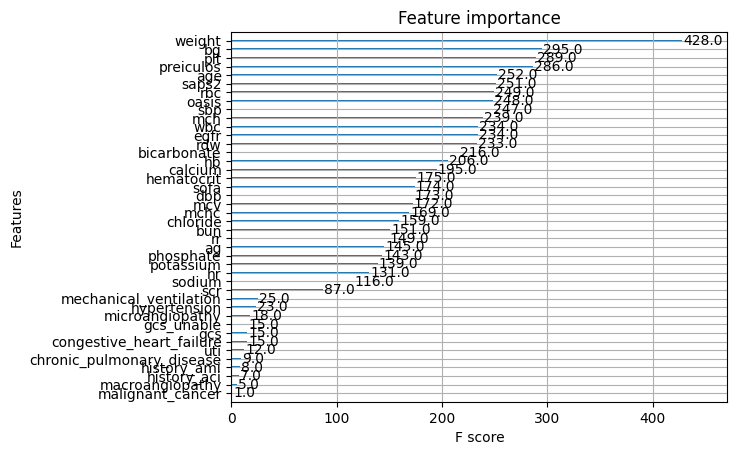

In [16]:
xgb.plot_importance(model)

ImportError: You must install graphviz to plot tree

<Figure size 3000x3000 with 0 Axes>

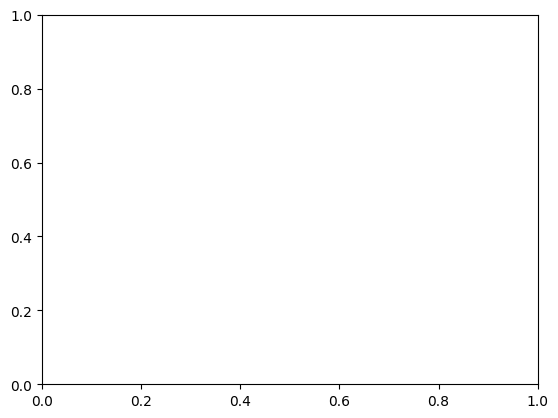

In [17]:
from matplotlib import pyplot as plt


plt.figure(figsize=(30, 30))
xgb.plot_tree(model, num_trees=3)

### Fill missing with knn

In [18]:
from sklearn.metrics import roc_auc_score
from utils.prepare_data import normalizeAndFillData


accuracy_score_list_val_knn = []
precision_score_list_val_knn = []
recall_score_list_val_knn = []
auc_score_list_val_knn = []
metric_dic_list_val_knn = []
for trainPatients, valPatients, testPatients in trainValTest():
    dfTrain = trainPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTrain = dfTrain.drop(columns=idColumns)

    dfVal = valPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfVal = dfVal.drop(columns=idColumns)

    dfTest = testPatients.getMeasuresBetween(
        pd.Timedelta(hours=-6), pd.Timedelta(hours=24), how
    )
    dfTest = dfTest.drop(columns=idColumns)

    dfTrain, dfTest, dfVal = normalizeAndFillData(dfTrain, dfTest, dfVal)

    X_train = dfTrain.drop(columns=[labelColumn])
    y_train = dfTrain[labelColumn]

    X_val = dfVal.drop(columns=[labelColumn])  # type: ignore
    y_val = dfVal[labelColumn]  # type: ignore

    X_test = dfTest.drop(columns=[labelColumn])
    y_test = dfTest[labelColumn]

    model = createModel()
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)])

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # For AUC

    accuracy_score_list_val_knn.append(accuracy_score(y_test, y_pred))
    precision_score_list_val_knn.append(precision_score(y_test, y_pred))
    recall_score_list_val_knn.append(recall_score(y_test, y_pred))
    auc_score_list_val_knn.append(roc_auc_score(y_test, y_pred_proba))



[0]	validation_0-logloss:0.66656


[1]	validation_0-logloss:0.66418


[2]	validation_0-logloss:0.66108


[3]	validation_0-logloss:0.65835


[4]	validation_0-logloss:0.65562


[5]	validation_0-logloss:0.65339


[6]	validation_0-logloss:0.65105


[7]	validation_0-logloss:0.64858


[8]	validation_0-logloss:0.64682


[9]	validation_0-logloss:0.64456


[10]	validation_0-logloss:0.64225


[11]	validation_0-logloss:0.63989


[12]	validation_0-logloss:0.63819


[13]	validation_0-logloss:0.63616


[14]	validation_0-logloss:0.63407


[15]	validation_0-logloss:0.63240


[16]	validation_0-logloss:0.63071


[17]	validation_0-logloss:0.62857


[18]	validation_0-logloss:0.62755


[19]	validation_0-logloss:0.62603


[20]	validation_0-logloss:0.62427


[21]	validation_0-logloss:0.62283


[22]	validation_0-logloss:0.62116


[23]	validation_0-logloss:0.62045


[24]	validation_0-logloss:0.61895


[25]	validation_0-logloss:0.61742


[26]	validation_0-logloss:0.61632


[27]	validation_0-logloss:0.61519


[28]	validation_0-logloss:0.61345


[29]	validation_0-logloss:0.61169


[30]	validation_0-logloss:0.61043


[31]	validation_0-logloss:0.60922


[32]	validation_0-logloss:0.60821


[33]	validation_0-logloss:0.60693


[34]	validation_0-logloss:0.60531


[35]	validation_0-logloss:0.60422


[36]	validation_0-logloss:0.60296


[37]	validation_0-logloss:0.60075


[38]	validation_0-logloss:0.59956


[39]	validation_0-logloss:0.59829


[40]	validation_0-logloss:0.59712


[41]	validation_0-logloss:0.59590


[42]	validation_0-logloss:0.59462


[43]	validation_0-logloss:0.59350


[44]	validation_0-logloss:0.59220


[45]	validation_0-logloss:0.59088


[46]	validation_0-logloss:0.58930


[47]	validation_0-logloss:0.58765


[48]	validation_0-logloss:0.58647


[49]	validation_0-logloss:0.58526


[50]	validation_0-logloss:0.58424


[51]	validation_0-logloss:0.58301


[52]	validation_0-logloss:0.58192


[53]	validation_0-logloss:0.58064


[54]	validation_0-logloss:0.57952


[55]	validation_0-logloss:0.57864


[56]	validation_0-logloss:0.57751


[57]	validation_0-logloss:0.57659


[58]	validation_0-logloss:0.57586


[59]	validation_0-logloss:0.57501


[60]	validation_0-logloss:0.57467


[61]	validation_0-logloss:0.57388


[62]	validation_0-logloss:0.57299


[63]	validation_0-logloss:0.57192


[64]	validation_0-logloss:0.57085


[65]	validation_0-logloss:0.56958


[66]	validation_0-logloss:0.56867


[67]	validation_0-logloss:0.56814


[68]	validation_0-logloss:0.56732


[69]	validation_0-logloss:0.56680


[70]	validation_0-logloss:0.56608


[71]	validation_0-logloss:0.56566


[72]	validation_0-logloss:0.56479


[73]	validation_0-logloss:0.56384


[74]	validation_0-logloss:0.56299


[75]	validation_0-logloss:0.56251


[76]	validation_0-logloss:0.56230


[77]	validation_0-logloss:0.56137


[78]	validation_0-logloss:0.56084


[79]	validation_0-logloss:0.56014


[80]	validation_0-logloss:0.55918


[81]	validation_0-logloss:0.55821


[82]	validation_0-logloss:0.55749


[83]	validation_0-logloss:0.55674


[84]	validation_0-logloss:0.55592


[85]	validation_0-logloss:0.55553


[86]	validation_0-logloss:0.55478


[87]	validation_0-logloss:0.55452


[88]	validation_0-logloss:0.55369


[89]	validation_0-logloss:0.55278


[90]	validation_0-logloss:0.55215


[91]	validation_0-logloss:0.55180


[92]	validation_0-logloss:0.55118


[93]	validation_0-logloss:0.55049


[94]	validation_0-logloss:0.54974


[95]	validation_0-logloss:0.54914


[96]	validation_0-logloss:0.54861


[97]	validation_0-logloss:0.54821


[98]	validation_0-logloss:0.54752


[99]	validation_0-logloss:0.54716


[100]	validation_0-logloss:0.54670


[101]	validation_0-logloss:0.54636


[102]	validation_0-logloss:0.54544


[103]	validation_0-logloss:0.54528


[104]	validation_0-logloss:0.54477


[105]	validation_0-logloss:0.54412


[106]	validation_0-logloss:0.54337


[107]	validation_0-logloss:0.54282


[108]	validation_0-logloss:0.54193


[109]	validation_0-logloss:0.54128


[110]	validation_0-logloss:0.54078


[111]	validation_0-logloss:0.53997


[112]	validation_0-logloss:0.53944


[113]	validation_0-logloss:0.53888


[114]	validation_0-logloss:0.53850


[115]	validation_0-logloss:0.53823


[116]	validation_0-logloss:0.53758


[117]	validation_0-logloss:0.53752


[118]	validation_0-logloss:0.53665


[119]	validation_0-logloss:0.53621


[120]	validation_0-logloss:0.53590


[121]	validation_0-logloss:0.53549


[122]	validation_0-logloss:0.53505


[123]	validation_0-logloss:0.53395


[124]	validation_0-logloss:0.53343


[125]	validation_0-logloss:0.53293


[126]	validation_0-logloss:0.53248


[127]	validation_0-logloss:0.53210


[128]	validation_0-logloss:0.53186


[129]	validation_0-logloss:0.53161


[130]	validation_0-logloss:0.53126


[131]	validation_0-logloss:0.53090


[132]	validation_0-logloss:0.53040


[133]	validation_0-logloss:0.53014


[134]	validation_0-logloss:0.53013


[135]	validation_0-logloss:0.53012


[136]	validation_0-logloss:0.52987


[137]	validation_0-logloss:0.52940


[138]	validation_0-logloss:0.52868


[139]	validation_0-logloss:0.52801


[140]	validation_0-logloss:0.52771


[141]	validation_0-logloss:0.52738


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:51] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[142]	validation_0-logloss:0.52696


[143]	validation_0-logloss:0.52641


[144]	validation_0-logloss:0.52626


[145]	validation_0-logloss:0.52618


[146]	validation_0-logloss:0.52578


[147]	validation_0-logloss:0.52521


[148]	validation_0-logloss:0.52502


[149]	validation_0-logloss:0.52480


[150]	validation_0-logloss:0.52469


[151]	validation_0-logloss:0.52449


[152]	validation_0-logloss:0.52420


[153]	validation_0-logloss:0.52430


[154]	validation_0-logloss:0.52401


[155]	validation_0-logloss:0.52392


[156]	validation_0-logloss:0.52377


[157]	validation_0-logloss:0.52367


[158]	validation_0-logloss:0.52357


[159]	validation_0-logloss:0.52290


[160]	validation_0-logloss:0.52291


[161]	validation_0-logloss:0.52300


[162]	validation_0-logloss:0.52262


[163]	validation_0-logloss:0.52191


[164]	validation_0-logloss:0.52153


[165]	validation_0-logloss:0.52160


[166]	validation_0-logloss:0.52132


[167]	validation_0-logloss:0.52105


[168]	validation_0-logloss:0.52062


[169]	validation_0-logloss:0.52085


[170]	validation_0-logloss:0.52065


[171]	validation_0-logloss:0.52044


[172]	validation_0-logloss:0.52034


[173]	validation_0-logloss:0.52016


[174]	validation_0-logloss:0.51999


[175]	validation_0-logloss:0.51970


[176]	validation_0-logloss:0.51966


[177]	validation_0-logloss:0.51916


[178]	validation_0-logloss:0.51841


[179]	validation_0-logloss:0.51853


[180]	validation_0-logloss:0.51854


[181]	validation_0-logloss:0.51798


[182]	validation_0-logloss:0.51802


[183]	validation_0-logloss:0.51784


[184]	validation_0-logloss:0.51761


[185]	validation_0-logloss:0.51801


[186]	validation_0-logloss:0.51801


[187]	validation_0-logloss:0.51768


[188]	validation_0-logloss:0.51730


[189]	validation_0-logloss:0.51692


[190]	validation_0-logloss:0.51650


[191]	validation_0-logloss:0.51620


[192]	validation_0-logloss:0.51634


[193]	validation_0-logloss:0.51656


[194]	validation_0-logloss:0.51614


[195]	validation_0-logloss:0.51598


[196]	validation_0-logloss:0.51568


[197]	validation_0-logloss:0.51554


[198]	validation_0-logloss:0.51585


[199]	validation_0-logloss:0.51586


[200]	validation_0-logloss:0.51563


[201]	validation_0-logloss:0.51551


[202]	validation_0-logloss:0.51541


[203]	validation_0-logloss:0.51501


[204]	validation_0-logloss:0.51478


[205]	validation_0-logloss:0.51460


[206]	validation_0-logloss:0.51455


[207]	validation_0-logloss:0.51436


[208]	validation_0-logloss:0.51420


[209]	validation_0-logloss:0.51421


[210]	validation_0-logloss:0.51434


[211]	validation_0-logloss:0.51413


[212]	validation_0-logloss:0.51370


[213]	validation_0-logloss:0.51355


[214]	validation_0-logloss:0.51338


[215]	validation_0-logloss:0.51328


[216]	validation_0-logloss:0.51338


[217]	validation_0-logloss:0.51311


[218]	validation_0-logloss:0.51299


[219]	validation_0-logloss:0.51262


[220]	validation_0-logloss:0.51239

[221]	validation_0-logloss:0.51258


[222]	validation_0-logloss:0.51253


[223]	validation_0-logloss:0.51248


[224]	validation_0-logloss:0.51254


[225]	validation_0-logloss:0.51244

[226]	validation_0-logloss:0.51231


[227]	validation_0-logloss:0.51205


[228]	validation_0-logloss:0.51217


[229]	validation_0-logloss:0.51205


[230]	validation_0-logloss:0.51223


[231]	validation_0-logloss:0.51222


[232]	validation_0-logloss:0.51196


[233]	validation_0-logloss:0.51208

[234]	validation_0-logloss:0.51216


[235]	validation_0-logloss:0.51200


[236]	validation_0-logloss:0.51209

[237]	validation_0-logloss:0.51187


[238]	validation_0-logloss:0.51185


[239]	validation_0-logloss:0.51190


[240]	validation_0-logloss:0.51190


[241]	validation_0-logloss:0.51194


[242]	validation_0-logloss:0.51180


[243]	validation_0-logloss:0.51170


[244]	validation_0-logloss:0.51216


[245]	validation_0-logloss:0.51220


[246]	validation_0-logloss:0.51207


[247]	validation_0-logloss:0.51193


[248]	validation_0-logloss:0.51197


[249]	validation_0-logloss:0.51182


[250]	validation_0-logloss:0.51151


[251]	validation_0-logloss:0.51139


[252]	validation_0-logloss:0.51166


[253]	validation_0-logloss:0.51171


[254]	validation_0-logloss:0.51162


[255]	validation_0-logloss:0.51156


[256]	validation_0-logloss:0.51152


[257]	validation_0-logloss:0.51152


[258]	validation_0-logloss:0.51144


[259]	validation_0-logloss:0.51114


[260]	validation_0-logloss:0.51127


[261]	validation_0-logloss:0.51122


[262]	validation_0-logloss:0.51109


[263]	validation_0-logloss:0.51090


[264]	validation_0-logloss:0.51051

[265]	validation_0-logloss:0.51042


[266]	validation_0-logloss:0.51027


[267]	validation_0-logloss:0.51046


[268]	validation_0-logloss:0.51030


[269]	validation_0-logloss:0.51022


[270]	validation_0-logloss:0.51018


[271]	validation_0-logloss:0.50983


[272]	validation_0-logloss:0.51004


[273]	validation_0-logloss:0.50999


[274]	validation_0-logloss:0.50981


[275]	validation_0-logloss:0.50969


[276]	validation_0-logloss:0.50961


[277]	validation_0-logloss:0.50946


[278]	validation_0-logloss:0.50969


[279]	validation_0-logloss:0.50938


[280]	validation_0-logloss:0.50961


[281]	validation_0-logloss:0.50972


[282]	validation_0-logloss:0.50998


[283]	validation_0-logloss:0.51004


[284]	validation_0-logloss:0.50972


[285]	validation_0-logloss:0.50963


[286]	validation_0-logloss:0.50956


[287]	validation_0-logloss:0.50951


[288]	validation_0-logloss:0.50947


[289]	validation_0-logloss:0.50971


[0]	validation_0-logloss:0.66789


[1]	validation_0-logloss:0.66560


[2]	validation_0-logloss:0.66320


[3]	validation_0-logloss:0.66070


[4]	validation_0-logloss:0.65828


[5]	validation_0-logloss:0.65586


[6]	validation_0-logloss:0.65353


[7]	validation_0-logloss:0.65137


[8]	validation_0-logloss:0.64938


[9]	validation_0-logloss:0.64753


[10]	validation_0-logloss:0.64527


[11]	validation_0-logloss:0.64362


[12]	validation_0-logloss:0.64200


[13]	validation_0-logloss:0.63987


[14]	validation_0-logloss:0.63807


[15]	validation_0-logloss:0.63631


[16]	validation_0-logloss:0.63449


[17]	validation_0-logloss:0.63275


[18]	validation_0-logloss:0.63122


[19]	validation_0-logloss:0.62989


[20]	validation_0-logloss:0.62813


[21]	validation_0-logloss:0.62622


[22]	validation_0-logloss:0.62440


[23]	validation_0-logloss:0.62290


[24]	validation_0-logloss:0.62141


[25]	validation_0-logloss:0.61991


[26]	validation_0-logloss:0.61872


[27]	validation_0-logloss:0.61724


[28]	validation_0-logloss:0.61547


[29]	validation_0-logloss:0.61418


[30]	validation_0-logloss:0.61316


[31]	validation_0-logloss:0.61172


[32]	validation_0-logloss:0.61031


[33]	validation_0-logloss:0.60875


[34]	validation_0-logloss:0.60804


[35]	validation_0-logloss:0.60667


[36]	validation_0-logloss:0.60549


[37]	validation_0-logloss:0.60407


[38]	validation_0-logloss:0.60285


[39]	validation_0-logloss:0.60145


[40]	validation_0-logloss:0.60046


[41]	validation_0-logloss:0.59929


[42]	validation_0-logloss:0.59828


[43]	validation_0-logloss:0.59741


[44]	validation_0-logloss:0.59605


[45]	validation_0-logloss:0.59492


[46]	validation_0-logloss:0.59375


[47]	validation_0-logloss:0.59241


[48]	validation_0-logloss:0.59097


[49]	validation_0-logloss:0.59003


[50]	validation_0-logloss:0.58883


[51]	validation_0-logloss:0.58783


[52]	validation_0-logloss:0.58693


[53]	validation_0-logloss:0.58572


[54]	validation_0-logloss:0.58442


[55]	validation_0-logloss:0.58349


[56]	validation_0-logloss:0.58272


[57]	validation_0-logloss:0.58158


[58]	validation_0-logloss:0.58084


[59]	validation_0-logloss:0.57993


[60]	validation_0-logloss:0.57943


[61]	validation_0-logloss:0.57838


[62]	validation_0-logloss:0.57755


[63]	validation_0-logloss:0.57673


[64]	validation_0-logloss:0.57579


[65]	validation_0-logloss:0.57468


[66]	validation_0-logloss:0.57381


[67]	validation_0-logloss:0.57271


[68]	validation_0-logloss:0.57206


[69]	validation_0-logloss:0.57158


[70]	validation_0-logloss:0.57056


[71]	validation_0-logloss:0.56937


[72]	validation_0-logloss:0.56895


[73]	validation_0-logloss:0.56793


[74]	validation_0-logloss:0.56719


[75]	validation_0-logloss:0.56619


[76]	validation_0-logloss:0.56541


[77]	validation_0-logloss:0.56448


[78]	validation_0-logloss:0.56384


[79]	validation_0-logloss:0.56317


[80]	validation_0-logloss:0.56245


[81]	validation_0-logloss:0.56162


[82]	validation_0-logloss:0.56127


[83]	validation_0-logloss:0.56056


[84]	validation_0-logloss:0.55974


[85]	validation_0-logloss:0.55939


[86]	validation_0-logloss:0.55849


[87]	validation_0-logloss:0.55734


[88]	validation_0-logloss:0.55704


[89]	validation_0-logloss:0.55634


[90]	validation_0-logloss:0.55566


[91]	validation_0-logloss:0.55483


[92]	validation_0-logloss:0.55421


[93]	validation_0-logloss:0.55358


[94]	validation_0-logloss:0.55250


[95]	validation_0-logloss:0.55178


[96]	validation_0-logloss:0.55130


[97]	validation_0-logloss:0.55048


[98]	validation_0-logloss:0.55010


[99]	validation_0-logloss:0.54940


[100]	validation_0-logloss:0.54898


[101]	validation_0-logloss:0.54826


[102]	validation_0-logloss:0.54762


[103]	validation_0-logloss:0.54684


[104]	validation_0-logloss:0.54652


[105]	validation_0-logloss:0.54587


[106]	validation_0-logloss:0.54521


[107]	validation_0-logloss:0.54509


[108]	validation_0-logloss:0.54453


[109]	validation_0-logloss:0.54358


[110]	validation_0-logloss:0.54325


[111]	validation_0-logloss:0.54263


[112]	validation_0-logloss:0.54235


[113]	validation_0-logloss:0.54209


[114]	validation_0-logloss:0.54126


[115]	validation_0-logloss:0.54050


[116]	validation_0-logloss:0.54017


[117]	validation_0-logloss:0.53957


[118]	validation_0-logloss:0.53915


[119]	validation_0-logloss:0.53863


[120]	validation_0-logloss:0.53831


[121]	validation_0-logloss:0.53764


[122]	validation_0-logloss:0.53727


[123]	validation_0-logloss:0.53648


[124]	validation_0-logloss:0.53623


[125]	validation_0-logloss:0.53609


[126]	validation_0-logloss:0.53573


[127]	validation_0-logloss:0.53538


[128]	validation_0-logloss:0.53507


[129]	validation_0-logloss:0.53462


[130]	validation_0-logloss:0.53415


[131]	validation_0-logloss:0.53383


[132]	validation_0-logloss:0.53335


[133]	validation_0-logloss:0.53272


[134]	validation_0-logloss:0.53240


[135]	validation_0-logloss:0.53169


[136]	validation_0-logloss:0.53157


[137]	validation_0-logloss:0.53117


[138]	validation_0-logloss:0.53114


[139]	validation_0-logloss:0.53082


[140]	validation_0-logloss:0.53071


[141]	validation_0-logloss:0.53053


[142]	validation_0-logloss:0.52997


[143]	validation_0-logloss:0.52923


[144]	validation_0-logloss:0.52917


[145]	validation_0-logloss:0.52906


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:07:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[146]	validation_0-logloss:0.52869


[147]	validation_0-logloss:0.52830


[148]	validation_0-logloss:0.52816


[149]	validation_0-logloss:0.52784


[150]	validation_0-logloss:0.52748


[151]	validation_0-logloss:0.52702


[152]	validation_0-logloss:0.52665


[153]	validation_0-logloss:0.52633


[154]	validation_0-logloss:0.52585

[155]	validation_0-logloss:0.52548


[156]	validation_0-logloss:0.52530


[157]	validation_0-logloss:0.52488


[158]	validation_0-logloss:0.52504


[159]	validation_0-logloss:0.52497


[160]	validation_0-logloss:0.52486


[161]	validation_0-logloss:0.52465


[162]	validation_0-logloss:0.52448


[163]	validation_0-logloss:0.52445


[164]	validation_0-logloss:0.52424


[165]	validation_0-logloss:0.52386


[166]	validation_0-logloss:0.52351


[167]	validation_0-logloss:0.52335


[168]	validation_0-logloss:0.52282


[169]	validation_0-logloss:0.52268


[170]	validation_0-logloss:0.52221


[171]	validation_0-logloss:0.52197


[172]	validation_0-logloss:0.52157


[173]	validation_0-logloss:0.52167


[174]	validation_0-logloss:0.52143


[175]	validation_0-logloss:0.52086


[176]	validation_0-logloss:0.52029


[177]	validation_0-logloss:0.51975


[178]	validation_0-logloss:0.51975


[179]	validation_0-logloss:0.51957


[180]	validation_0-logloss:0.51926


[181]	validation_0-logloss:0.51922


[182]	validation_0-logloss:0.51924


[183]	validation_0-logloss:0.51885


[184]	validation_0-logloss:0.51854


[185]	validation_0-logloss:0.51863


[186]	validation_0-logloss:0.51877


[187]	validation_0-logloss:0.51853


[188]	validation_0-logloss:0.51815


[189]	validation_0-logloss:0.51822


[190]	validation_0-logloss:0.51800


[191]	validation_0-logloss:0.51778


[192]	validation_0-logloss:0.51754


[193]	validation_0-logloss:0.51762


[194]	validation_0-logloss:0.51745


[195]	validation_0-logloss:0.51763


[196]	validation_0-logloss:0.51773


[197]	validation_0-logloss:0.51750


[198]	validation_0-logloss:0.51720


[199]	validation_0-logloss:0.51685


[200]	validation_0-logloss:0.51672


[201]	validation_0-logloss:0.51643


[202]	validation_0-logloss:0.51645


[203]	validation_0-logloss:0.51608


[204]	validation_0-logloss:0.51568


[205]	validation_0-logloss:0.51564


[206]	validation_0-logloss:0.51553


[207]	validation_0-logloss:0.51539


[208]	validation_0-logloss:0.51544


[209]	validation_0-logloss:0.51546


[210]	validation_0-logloss:0.51542


[211]	validation_0-logloss:0.51513


[212]	validation_0-logloss:0.51482


[213]	validation_0-logloss:0.51455


[214]	validation_0-logloss:0.51409


[215]	validation_0-logloss:0.51414


[216]	validation_0-logloss:0.51411


[217]	validation_0-logloss:0.51424


[218]	validation_0-logloss:0.51405


[219]	validation_0-logloss:0.51386

[220]	validation_0-logloss:0.51381


[221]	validation_0-logloss:0.51359


[222]	validation_0-logloss:0.51323


[223]	validation_0-logloss:0.51315


[224]	validation_0-logloss:0.51279


[225]	validation_0-logloss:0.51268


[226]	validation_0-logloss:0.51269


[227]	validation_0-logloss:0.51271

[228]	validation_0-logloss:0.51286


[229]	validation_0-logloss:0.51273


[230]	validation_0-logloss:0.51257


[231]	validation_0-logloss:0.51247


[232]	validation_0-logloss:0.51250


[233]	validation_0-logloss:0.51273


[234]	validation_0-logloss:0.51221


[235]	validation_0-logloss:0.51237


[236]	validation_0-logloss:0.51199


[237]	validation_0-logloss:0.51199


[238]	validation_0-logloss:0.51175


[239]	validation_0-logloss:0.51181


[240]	validation_0-logloss:0.51175


[241]	validation_0-logloss:0.51166


[242]	validation_0-logloss:0.51169


[243]	validation_0-logloss:0.51160


[244]	validation_0-logloss:0.51130


[245]	validation_0-logloss:0.51143


[246]	validation_0-logloss:0.51172


[247]	validation_0-logloss:0.51159


[248]	validation_0-logloss:0.51150


[249]	validation_0-logloss:0.51156


[250]	validation_0-logloss:0.51172


[251]	validation_0-logloss:0.51170


[252]	validation_0-logloss:0.51174


[253]	validation_0-logloss:0.51167


[0]	validation_0-logloss:0.66813


[1]	validation_0-logloss:0.66638


[2]	validation_0-logloss:0.66504


[3]	validation_0-logloss:0.66336


[4]	validation_0-logloss:0.66077


[5]	validation_0-logloss:0.65904


[6]	validation_0-logloss:0.65741


[7]	validation_0-logloss:0.65524


[8]	validation_0-logloss:0.65355


[9]	validation_0-logloss:0.65196


[10]	validation_0-logloss:0.65012


[11]	validation_0-logloss:0.64862


[12]	validation_0-logloss:0.64729


[13]	validation_0-logloss:0.64605


[14]	validation_0-logloss:0.64398


[15]	validation_0-logloss:0.64219


[16]	validation_0-logloss:0.64076


[17]	validation_0-logloss:0.63927


[18]	validation_0-logloss:0.63870


[19]	validation_0-logloss:0.63698


[20]	validation_0-logloss:0.63538


[21]	validation_0-logloss:0.63376


[22]	validation_0-logloss:0.63242


[23]	validation_0-logloss:0.63037


[24]	validation_0-logloss:0.62871


[25]	validation_0-logloss:0.62707


[26]	validation_0-logloss:0.62560


[27]	validation_0-logloss:0.62474


[28]	validation_0-logloss:0.62333


[29]	validation_0-logloss:0.62187


[30]	validation_0-logloss:0.62078


[31]	validation_0-logloss:0.62043


[32]	validation_0-logloss:0.61900


[33]	validation_0-logloss:0.61800


[34]	validation_0-logloss:0.61719


[35]	validation_0-logloss:0.61586


[36]	validation_0-logloss:0.61468


[37]	validation_0-logloss:0.61360


[38]	validation_0-logloss:0.61284


[39]	validation_0-logloss:0.61168


[40]	validation_0-logloss:0.61067


[41]	validation_0-logloss:0.60990


[42]	validation_0-logloss:0.60878


[43]	validation_0-logloss:0.60776


[44]	validation_0-logloss:0.60716


[45]	validation_0-logloss:0.60602


[46]	validation_0-logloss:0.60525


[47]	validation_0-logloss:0.60366


[48]	validation_0-logloss:0.60274


[49]	validation_0-logloss:0.60185


[50]	validation_0-logloss:0.60053


[51]	validation_0-logloss:0.59894


[52]	validation_0-logloss:0.59795


[53]	validation_0-logloss:0.59690


[54]	validation_0-logloss:0.59606


[55]	validation_0-logloss:0.59493


[56]	validation_0-logloss:0.59424


[57]	validation_0-logloss:0.59335


[58]	validation_0-logloss:0.59220


[59]	validation_0-logloss:0.59126


[60]	validation_0-logloss:0.59036


[61]	validation_0-logloss:0.58935


[62]	validation_0-logloss:0.58877


[63]	validation_0-logloss:0.58799


[64]	validation_0-logloss:0.58727


[65]	validation_0-logloss:0.58682


[66]	validation_0-logloss:0.58640


[67]	validation_0-logloss:0.58567


[68]	validation_0-logloss:0.58489


[69]	validation_0-logloss:0.58399


[70]	validation_0-logloss:0.58345


[71]	validation_0-logloss:0.58285


[72]	validation_0-logloss:0.58229


[73]	validation_0-logloss:0.58146


[74]	validation_0-logloss:0.58049


[75]	validation_0-logloss:0.57993


[76]	validation_0-logloss:0.57938


[77]	validation_0-logloss:0.57885


[78]	validation_0-logloss:0.57801


[79]	validation_0-logloss:0.57787


[80]	validation_0-logloss:0.57737


[81]	validation_0-logloss:0.57642


[82]	validation_0-logloss:0.57593


[83]	validation_0-logloss:0.57565


[84]	validation_0-logloss:0.57494


[85]	validation_0-logloss:0.57434


[86]	validation_0-logloss:0.57367


[87]	validation_0-logloss:0.57335


[88]	validation_0-logloss:0.57276


[89]	validation_0-logloss:0.57252


[90]	validation_0-logloss:0.57196


[91]	validation_0-logloss:0.57176


[92]	validation_0-logloss:0.57146


[93]	validation_0-logloss:0.57111


[94]	validation_0-logloss:0.57062


[95]	validation_0-logloss:0.57026


[96]	validation_0-logloss:0.56987


[97]	validation_0-logloss:0.56938


[98]	validation_0-logloss:0.56914


[99]	validation_0-logloss:0.56899


[100]	validation_0-logloss:0.56862


[101]	validation_0-logloss:0.56855


[102]	validation_0-logloss:0.56846


[103]	validation_0-logloss:0.56783


[104]	validation_0-logloss:0.56727


[105]	validation_0-logloss:0.56741


[106]	validation_0-logloss:0.56707


[107]	validation_0-logloss:0.56693


[108]	validation_0-logloss:0.56671


[109]	validation_0-logloss:0.56621


[110]	validation_0-logloss:0.56576


[111]	validation_0-logloss:0.56545


[112]	validation_0-logloss:0.56509


[113]	validation_0-logloss:0.56530


[114]	validation_0-logloss:0.56502


[115]	validation_0-logloss:0.56467


[116]	validation_0-logloss:0.56466


[117]	validation_0-logloss:0.56375


[118]	validation_0-logloss:0.56340


[119]	validation_0-logloss:0.56304


[120]	validation_0-logloss:0.56259


[121]	validation_0-logloss:0.56205


[122]	validation_0-logloss:0.56171


[123]	validation_0-logloss:0.56104


[124]	validation_0-logloss:0.56159


[125]	validation_0-logloss:0.56093


[126]	validation_0-logloss:0.56078


[127]	validation_0-logloss:0.56084


[128]	validation_0-logloss:0.56023


[129]	validation_0-logloss:0.56033


[130]	validation_0-logloss:0.56010


[131]	validation_0-logloss:0.55999


[132]	validation_0-logloss:0.55979


[133]	validation_0-logloss:0.55976


[134]	validation_0-logloss:0.55952


[135]	validation_0-logloss:0.55934


[136]	validation_0-logloss:0.55910


[137]	validation_0-logloss:0.55881


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:08:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[138]	validation_0-logloss:0.55851


[139]	validation_0-logloss:0.55820


[140]	validation_0-logloss:0.55780


[141]	validation_0-logloss:0.55743


[142]	validation_0-logloss:0.55747


[143]	validation_0-logloss:0.55723


[144]	validation_0-logloss:0.55745


[145]	validation_0-logloss:0.55765


[146]	validation_0-logloss:0.55760


[147]	validation_0-logloss:0.55797


[148]	validation_0-logloss:0.55777


[149]	validation_0-logloss:0.55780


[150]	validation_0-logloss:0.55800


[151]	validation_0-logloss:0.55789


[152]	validation_0-logloss:0.55780


[153]	validation_0-logloss:0.55765


[0]	validation_0-logloss:0.66794


[1]	validation_0-logloss:0.66547


[2]	validation_0-logloss:0.66303


[3]	validation_0-logloss:0.66120


[4]	validation_0-logloss:0.65928


[5]	validation_0-logloss:0.65703


[6]	validation_0-logloss:0.65476


[7]	validation_0-logloss:0.65289


[8]	validation_0-logloss:0.65113


[9]	validation_0-logloss:0.64947


[10]	validation_0-logloss:0.64775


[11]	validation_0-logloss:0.64633


[12]	validation_0-logloss:0.64430


[13]	validation_0-logloss:0.64197


[14]	validation_0-logloss:0.64011


[15]	validation_0-logloss:0.63815


[16]	validation_0-logloss:0.63614


[17]	validation_0-logloss:0.63422


[18]	validation_0-logloss:0.63282


[19]	validation_0-logloss:0.63149


[20]	validation_0-logloss:0.63017


[21]	validation_0-logloss:0.62854


[22]	validation_0-logloss:0.62698


[23]	validation_0-logloss:0.62550


[24]	validation_0-logloss:0.62398


[25]	validation_0-logloss:0.62211


[26]	validation_0-logloss:0.62010


[27]	validation_0-logloss:0.61886


[28]	validation_0-logloss:0.61727


[29]	validation_0-logloss:0.61600


[30]	validation_0-logloss:0.61520


[31]	validation_0-logloss:0.61369


[32]	validation_0-logloss:0.61302


[33]	validation_0-logloss:0.61172


[34]	validation_0-logloss:0.61072


[35]	validation_0-logloss:0.60905


[36]	validation_0-logloss:0.60754


[37]	validation_0-logloss:0.60639


[38]	validation_0-logloss:0.60538


[39]	validation_0-logloss:0.60420


[40]	validation_0-logloss:0.60317


[41]	validation_0-logloss:0.60198


[42]	validation_0-logloss:0.60066


[43]	validation_0-logloss:0.60032


[44]	validation_0-logloss:0.59922


[45]	validation_0-logloss:0.59774


[46]	validation_0-logloss:0.59672


[47]	validation_0-logloss:0.59561


[48]	validation_0-logloss:0.59446


[49]	validation_0-logloss:0.59313


[50]	validation_0-logloss:0.59189


[51]	validation_0-logloss:0.59111


[52]	validation_0-logloss:0.59039


[53]	validation_0-logloss:0.58936


[54]	validation_0-logloss:0.58809


[55]	validation_0-logloss:0.58725


[56]	validation_0-logloss:0.58627


[57]	validation_0-logloss:0.58550


[58]	validation_0-logloss:0.58463


[59]	validation_0-logloss:0.58373


[60]	validation_0-logloss:0.58289


[61]	validation_0-logloss:0.58146


[62]	validation_0-logloss:0.58035


[63]	validation_0-logloss:0.57972


[64]	validation_0-logloss:0.57909


[65]	validation_0-logloss:0.57871


[66]	validation_0-logloss:0.57816


[67]	validation_0-logloss:0.57791


[68]	validation_0-logloss:0.57706


[69]	validation_0-logloss:0.57646


[70]	validation_0-logloss:0.57581


[71]	validation_0-logloss:0.57534


[72]	validation_0-logloss:0.57474


[73]	validation_0-logloss:0.57389


[74]	validation_0-logloss:0.57353


[75]	validation_0-logloss:0.57329


[76]	validation_0-logloss:0.57279


[77]	validation_0-logloss:0.57232


[78]	validation_0-logloss:0.57124


[79]	validation_0-logloss:0.57065


[80]	validation_0-logloss:0.56992


[81]	validation_0-logloss:0.56963


[82]	validation_0-logloss:0.56891


[83]	validation_0-logloss:0.56854


[84]	validation_0-logloss:0.56806


[85]	validation_0-logloss:0.56743


[86]	validation_0-logloss:0.56703


[87]	validation_0-logloss:0.56697


[88]	validation_0-logloss:0.56611


[89]	validation_0-logloss:0.56601


[90]	validation_0-logloss:0.56518


[91]	validation_0-logloss:0.56481


[92]	validation_0-logloss:0.56413


[93]	validation_0-logloss:0.56350


[94]	validation_0-logloss:0.56315


[95]	validation_0-logloss:0.56289


[96]	validation_0-logloss:0.56220


[97]	validation_0-logloss:0.56183


[98]	validation_0-logloss:0.56156


[99]	validation_0-logloss:0.56109


[100]	validation_0-logloss:0.56040


[101]	validation_0-logloss:0.55960


[102]	validation_0-logloss:0.55907


[103]	validation_0-logloss:0.55865


[104]	validation_0-logloss:0.55794


[105]	validation_0-logloss:0.55777


[106]	validation_0-logloss:0.55711


[107]	validation_0-logloss:0.55657


[108]	validation_0-logloss:0.55593


[109]	validation_0-logloss:0.55529


[110]	validation_0-logloss:0.55506


[111]	validation_0-logloss:0.55517


[112]	validation_0-logloss:0.55456


[113]	validation_0-logloss:0.55445


[114]	validation_0-logloss:0.55416


[115]	validation_0-logloss:0.55377


[116]	validation_0-logloss:0.55348


[117]	validation_0-logloss:0.55343


[118]	validation_0-logloss:0.55294


[119]	validation_0-logloss:0.55267


[120]	validation_0-logloss:0.55222


[121]	validation_0-logloss:0.55175


[122]	validation_0-logloss:0.55136


[123]	validation_0-logloss:0.55089


[124]	validation_0-logloss:0.55083


[125]	validation_0-logloss:0.55029


[126]	validation_0-logloss:0.54976


[127]	validation_0-logloss:0.54988


[128]	validation_0-logloss:0.54977


[129]	validation_0-logloss:0.55001


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:08:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[130]	validation_0-logloss:0.54986


[131]	validation_0-logloss:0.54966


[132]	validation_0-logloss:0.54950


[133]	validation_0-logloss:0.54924


[134]	validation_0-logloss:0.54931


[135]	validation_0-logloss:0.54941


[136]	validation_0-logloss:0.54948

[137]	validation_0-logloss:0.54920


[138]	validation_0-logloss:0.54893


[139]	validation_0-logloss:0.54910


[140]	validation_0-logloss:0.54907


[141]	validation_0-logloss:0.54891


[142]	validation_0-logloss:0.54841


[143]	validation_0-logloss:0.54774


[144]	validation_0-logloss:0.54766


[145]	validation_0-logloss:0.54762


[146]	validation_0-logloss:0.54734


[147]	validation_0-logloss:0.54718


[148]	validation_0-logloss:0.54690


[149]	validation_0-logloss:0.54683


[150]	validation_0-logloss:0.54642


[151]	validation_0-logloss:0.54626


[152]	validation_0-logloss:0.54605


[153]	validation_0-logloss:0.54585


[154]	validation_0-logloss:0.54546


[155]	validation_0-logloss:0.54512


[156]	validation_0-logloss:0.54507


[157]	validation_0-logloss:0.54460


[158]	validation_0-logloss:0.54402


[159]	validation_0-logloss:0.54372


[160]	validation_0-logloss:0.54356


[161]	validation_0-logloss:0.54335


[162]	validation_0-logloss:0.54325


[163]	validation_0-logloss:0.54304


[164]	validation_0-logloss:0.54289


[165]	validation_0-logloss:0.54264


[166]	validation_0-logloss:0.54284


[167]	validation_0-logloss:0.54276


[168]	validation_0-logloss:0.54247


[169]	validation_0-logloss:0.54233


[170]	validation_0-logloss:0.54232


[171]	validation_0-logloss:0.54201


[172]	validation_0-logloss:0.54203


[173]	validation_0-logloss:0.54192


[174]	validation_0-logloss:0.54190


[175]	validation_0-logloss:0.54147


[176]	validation_0-logloss:0.54154


[177]	validation_0-logloss:0.54142


[178]	validation_0-logloss:0.54111


[179]	validation_0-logloss:0.54097


[180]	validation_0-logloss:0.54071


[181]	validation_0-logloss:0.54045


[182]	validation_0-logloss:0.54028


[183]	validation_0-logloss:0.54042


[184]	validation_0-logloss:0.54038


[185]	validation_0-logloss:0.54015


[186]	validation_0-logloss:0.53965


[187]	validation_0-logloss:0.53948


[188]	validation_0-logloss:0.53943


[189]	validation_0-logloss:0.53943


[190]	validation_0-logloss:0.53913


[191]	validation_0-logloss:0.53888


[192]	validation_0-logloss:0.53875


[193]	validation_0-logloss:0.53882


[194]	validation_0-logloss:0.53873


[195]	validation_0-logloss:0.53866


[196]	validation_0-logloss:0.53832


[197]	validation_0-logloss:0.53811


[198]	validation_0-logloss:0.53792


[199]	validation_0-logloss:0.53787


[200]	validation_0-logloss:0.53826


[201]	validation_0-logloss:0.53818


[202]	validation_0-logloss:0.53805


[203]	validation_0-logloss:0.53787


[204]	validation_0-logloss:0.53820


[205]	validation_0-logloss:0.53808


[206]	validation_0-logloss:0.53792


[207]	validation_0-logloss:0.53801


[208]	validation_0-logloss:0.53812


[209]	validation_0-logloss:0.53800


[210]	validation_0-logloss:0.53785


[211]	validation_0-logloss:0.53815


[212]	validation_0-logloss:0.53770


[213]	validation_0-logloss:0.53806


[214]	validation_0-logloss:0.53783


[215]	validation_0-logloss:0.53776


[216]	validation_0-logloss:0.53808


[217]	validation_0-logloss:0.53807


[218]	validation_0-logloss:0.53815


[219]	validation_0-logloss:0.53811


[220]	validation_0-logloss:0.53795


[221]	validation_0-logloss:0.53794

[222]	validation_0-logloss:0.53806


[0]	validation_0-logloss:0.66765


[1]	validation_0-logloss:0.66524


[2]	validation_0-logloss:0.66259


[3]	validation_0-logloss:0.66084


[4]	validation_0-logloss:0.65835


[5]	validation_0-logloss:0.65676


[6]	validation_0-logloss:0.65457


[7]	validation_0-logloss:0.65267


[8]	validation_0-logloss:0.65077


[9]	validation_0-logloss:0.64896


[10]	validation_0-logloss:0.64709


[11]	validation_0-logloss:0.64589


[12]	validation_0-logloss:0.64402


[13]	validation_0-logloss:0.64174


[14]	validation_0-logloss:0.63977


[15]	validation_0-logloss:0.63783


[16]	validation_0-logloss:0.63580


[17]	validation_0-logloss:0.63419


[18]	validation_0-logloss:0.63243


[19]	validation_0-logloss:0.63057


[20]	validation_0-logloss:0.62897


[21]	validation_0-logloss:0.62742


[22]	validation_0-logloss:0.62601


[23]	validation_0-logloss:0.62418


[24]	validation_0-logloss:0.62295


[25]	validation_0-logloss:0.62153


[26]	validation_0-logloss:0.62077


[27]	validation_0-logloss:0.61945


[28]	validation_0-logloss:0.61774


[29]	validation_0-logloss:0.61687


[30]	validation_0-logloss:0.61500


[31]	validation_0-logloss:0.61349


[32]	validation_0-logloss:0.61252


[33]	validation_0-logloss:0.61141


[34]	validation_0-logloss:0.61013


[35]	validation_0-logloss:0.60898


[36]	validation_0-logloss:0.60781


[37]	validation_0-logloss:0.60676


[38]	validation_0-logloss:0.60605


[39]	validation_0-logloss:0.60504


[40]	validation_0-logloss:0.60415


[41]	validation_0-logloss:0.60325


[42]	validation_0-logloss:0.60202


[43]	validation_0-logloss:0.60124


[44]	validation_0-logloss:0.60001


[45]	validation_0-logloss:0.59891


[46]	validation_0-logloss:0.59773


[47]	validation_0-logloss:0.59673


[48]	validation_0-logloss:0.59570


[49]	validation_0-logloss:0.59448


[50]	validation_0-logloss:0.59342


[51]	validation_0-logloss:0.59233


[52]	validation_0-logloss:0.59150


[53]	validation_0-logloss:0.59056


[54]	validation_0-logloss:0.58940


[55]	validation_0-logloss:0.58893


[56]	validation_0-logloss:0.58817


[57]	validation_0-logloss:0.58721


[58]	validation_0-logloss:0.58643


[59]	validation_0-logloss:0.58593


[60]	validation_0-logloss:0.58503


[61]	validation_0-logloss:0.58416


[62]	validation_0-logloss:0.58312


[63]	validation_0-logloss:0.58232


[64]	validation_0-logloss:0.58174


[65]	validation_0-logloss:0.58108


[66]	validation_0-logloss:0.58038


[67]	validation_0-logloss:0.57978


[68]	validation_0-logloss:0.57897


[69]	validation_0-logloss:0.57861


[70]	validation_0-logloss:0.57775


[71]	validation_0-logloss:0.57790


[72]	validation_0-logloss:0.57732


[73]	validation_0-logloss:0.57692


[74]	validation_0-logloss:0.57613


[75]	validation_0-logloss:0.57596


[76]	validation_0-logloss:0.57526


[77]	validation_0-logloss:0.57465


[78]	validation_0-logloss:0.57373


[79]	validation_0-logloss:0.57274


[80]	validation_0-logloss:0.57211


[81]	validation_0-logloss:0.57145


[82]	validation_0-logloss:0.57063


[83]	validation_0-logloss:0.57019


[84]	validation_0-logloss:0.56975


[85]	validation_0-logloss:0.56961


[86]	validation_0-logloss:0.56899


[87]	validation_0-logloss:0.56851


[88]	validation_0-logloss:0.56797


[89]	validation_0-logloss:0.56740


[90]	validation_0-logloss:0.56687


[91]	validation_0-logloss:0.56653


[92]	validation_0-logloss:0.56617


[93]	validation_0-logloss:0.56578


[94]	validation_0-logloss:0.56593


[95]	validation_0-logloss:0.56564


[96]	validation_0-logloss:0.56534


[97]	validation_0-logloss:0.56473


[98]	validation_0-logloss:0.56436


[99]	validation_0-logloss:0.56406


[100]	validation_0-logloss:0.56330


[101]	validation_0-logloss:0.56295


[102]	validation_0-logloss:0.56256


[103]	validation_0-logloss:0.56205


[104]	validation_0-logloss:0.56158


[105]	validation_0-logloss:0.56123


[106]	validation_0-logloss:0.56079


[107]	validation_0-logloss:0.56072


[108]	validation_0-logloss:0.55983


[109]	validation_0-logloss:0.55951


[110]	validation_0-logloss:0.55915


[111]	validation_0-logloss:0.55864


[112]	validation_0-logloss:0.55837


[113]	validation_0-logloss:0.55813


[114]	validation_0-logloss:0.55814


[115]	validation_0-logloss:0.55824


[116]	validation_0-logloss:0.55817


[117]	validation_0-logloss:0.55758


[118]	validation_0-logloss:0.55722


[119]	validation_0-logloss:0.55706


[120]	validation_0-logloss:0.55684


[121]	validation_0-logloss:0.55672


[122]	validation_0-logloss:0.55644


[123]	validation_0-logloss:0.55566


[124]	validation_0-logloss:0.55531


[125]	validation_0-logloss:0.55501


[126]	validation_0-logloss:0.55446


[127]	validation_0-logloss:0.55464


[128]	validation_0-logloss:0.55433


/home/tu/codepy/hust.year2023.PredictingRiskDiabeticKetoacidosis-associatedKidneyInjury/.venv/lib/python3.12/site-packages/xgboost/core.py:160: UserWarning: [10:08:24] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[129]	validation_0-logloss:0.55404


[130]	validation_0-logloss:0.55384


[131]	validation_0-logloss:0.55359


[132]	validation_0-logloss:0.55319


[133]	validation_0-logloss:0.55270


[134]	validation_0-logloss:0.55234


[135]	validation_0-logloss:0.55213


[136]	validation_0-logloss:0.55184


[137]	validation_0-logloss:0.55147


[138]	validation_0-logloss:0.55120


[139]	validation_0-logloss:0.55093


[140]	validation_0-logloss:0.55069


[141]	validation_0-logloss:0.55076


[142]	validation_0-logloss:0.55091


[143]	validation_0-logloss:0.55078


[144]	validation_0-logloss:0.55039


[145]	validation_0-logloss:0.55015


[146]	validation_0-logloss:0.54986


[147]	validation_0-logloss:0.54947


[148]	validation_0-logloss:0.54927


[149]	validation_0-logloss:0.54885


[150]	validation_0-logloss:0.54856


[151]	validation_0-logloss:0.54809


[152]	validation_0-logloss:0.54799


[153]	validation_0-logloss:0.54765


[154]	validation_0-logloss:0.54700


[155]	validation_0-logloss:0.54680


[156]	validation_0-logloss:0.54658


[157]	validation_0-logloss:0.54627


[158]	validation_0-logloss:0.54642


[159]	validation_0-logloss:0.54600


[160]	validation_0-logloss:0.54585


[161]	validation_0-logloss:0.54583


[162]	validation_0-logloss:0.54542


[163]	validation_0-logloss:0.54558


[164]	validation_0-logloss:0.54549


[165]	validation_0-logloss:0.54539


[166]	validation_0-logloss:0.54524


[167]	validation_0-logloss:0.54553


[168]	validation_0-logloss:0.54535


[169]	validation_0-logloss:0.54504


[170]	validation_0-logloss:0.54511


[171]	validation_0-logloss:0.54443


[172]	validation_0-logloss:0.54428


[173]	validation_0-logloss:0.54405


[174]	validation_0-logloss:0.54396


[175]	validation_0-logloss:0.54391


[176]	validation_0-logloss:0.54376


[177]	validation_0-logloss:0.54369


[178]	validation_0-logloss:0.54382


[179]	validation_0-logloss:0.54380


[180]	validation_0-logloss:0.54337


[181]	validation_0-logloss:0.54320


[182]	validation_0-logloss:0.54325


[183]	validation_0-logloss:0.54291


[184]	validation_0-logloss:0.54271


[185]	validation_0-logloss:0.54253


[186]	validation_0-logloss:0.54256


[187]	validation_0-logloss:0.54239


[188]	validation_0-logloss:0.54177


[189]	validation_0-logloss:0.54182


[190]	validation_0-logloss:0.54138


[191]	validation_0-logloss:0.54134


[192]	validation_0-logloss:0.54131


[193]	validation_0-logloss:0.54126


[194]	validation_0-logloss:0.54117


[195]	validation_0-logloss:0.54100


[196]	validation_0-logloss:0.54089


[197]	validation_0-logloss:0.54099

[198]	validation_0-logloss:0.54095


[199]	validation_0-logloss:0.54092


[200]	validation_0-logloss:0.54085


[201]	validation_0-logloss:0.54099


[202]	validation_0-logloss:0.54098


[203]	validation_0-logloss:0.54133


[204]	validation_0-logloss:0.54149


[205]	validation_0-logloss:0.54148


[206]	validation_0-logloss:0.54167


[207]	validation_0-logloss:0.54122


[208]	validation_0-logloss:0.54105


[209]	validation_0-logloss:0.54101


In [19]:
print(f"Average AUC: {np.mean(auc_score_list_val_knn)}")
print(f"Average Accuracy: {np.mean(accuracy_score_list_val_knn)}")
print(f"Average Precision: {np.mean(precision_score_list_val_knn)}")
print(f"Average Recall: {np.mean(recall_score_list_val_knn)}")

Average AUC: 0.7911292763281813
Average Accuracy: 0.7396419875861596
Average Precision: 0.7053567746250673
Average Recall: 0.5865173572228443
